In [7]:
import numpy as np
import pandas as pd
import pickle
import plotnine as pn
import pyranges as pr
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from pyarrow.parquet import ParquetFile

import dataloader_clean

In [75]:
gtf_file = "/s/genomes/Gencode/Gencode_human/release_34/GRCh37_mapping/gencode.v34lift37.annotation.gtf.gz"
genome_annotation = pr.read_gtf(gtf_file)
gene_annotation = genome_annotation[genome_annotation.Feature=="gene"]
gene_annotation


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,...,remap_original_location,remap_status,remap_num_mappings,remap_target_status,ont,protein_id,ccdsid,gene_status,transcript_status,remap_substituted_missing_target
0,chr1,HAVANA,gene,11868,14409,.,+,.,ENSG00000223972.5_3,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,gene,29553,31109,.,+,.,ENSG00000243485.5_7,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,gene,52472,53312,.,+,.,ENSG00000268020.3_4,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,HAVANA,gene,57597,64116,.,+,.,ENSG00000240361.2_4,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,HAVANA,gene,65418,71585,.,+,.,ENSG00000186092.6_5,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62487,chrY,HAVANA,gene,59161253,59162245,.,-,.,ENSG00000237801.6_5_PAR_Y,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
62488,chrY,HAVANA,gene,59311662,59311996,.,-,.,ENSG00000228410.6_4_PAR_Y,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
62489,chrY,HAVANA,gene,59318040,59318920,.,-,.,ENSG00000223484.7_4_PAR_Y,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN
62490,chrY,HAVANA,gene,59347293,59349508,.,-,.,ENSG00000185203.12_8_PAR_Y,NaN,...,NaN,full_contig,1,overlap,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# Filtering Functions

def get_vars_by_gene(var_mac_parquet_file, gene_id, gene_annotation, padding = 0, fillna = True):
    var_names = ParquetFile(var_mac_parquet_file).schema.names
    split_var_names = pd.Series(var_names[6:]).str.split(":", expand=True)
    
    variants = pr.from_dict({
        "Chromosome":split_var_names[0].astype(str), 
        "Start":split_var_names[1].astype(int),
        "End":split_var_names[1].astype(int)+1,
        "var_name":pd.Series(var_names[6:])
    })
    
    gene_annotation_expanded = gene_annotation.copy()
    gene_annotation_expanded.Start = gene_annotation_expanded.Start - padding
    gene_annotation_expanded.End = gene_annotation_expanded.End + padding
    
    included_vars = variants.intersect(gene_annotation_expanded[gene_annotation_expanded.gene_id.str.startswith(gene_id)])
    included_vars = included_vars.as_df()["var_name"].to_list() if included_vars else []
    mac_df = pd.read_parquet(var_mac_parquet_file, columns = ["IID"]+included_vars)
    
    mac_df[included_vars] = mac_df[included_vars].fillna(mac_df[included_vars].median()).astype("Int8") if fillna else mac_df[included_vars].astype("Int8")
    return mac_df


def get_common_variant_covariates(gene_id, ind_list, trait=None, phenocode=None, padding=100_000):
    if phenocode is None:
        phenocode = phenocode_dict[trait]
        
    # mac_index_vars_parquet = f"/s/project/deeprvat/clumping/clumping_shubhankar/{phenocode}.0/GWAS_variants_clumped_mac.parquet" # Eva's results, filtered for Caucasians and more stringent p-val
    mac_index_vars_parquet = f"/s/project/uk_biobank/processed/clumping/{phenocode}/GWAS_variants_clumped_mac.parquet"
    res_all = get_vars_by_gene(mac_index_vars_parquet, gene_id, gene_annotation, padding = 100_000)
    res_all['individual'] = res_all['IID'].str.split('_').str[0]
    res = res_all.drop(columns='IID')
    # res = res[res.individual.isin(plot_dt.individual)]
    res = res[res.individual.isin(ind_list)]
    res.set_index('individual', inplace=True)
    res = 2 - res
    res.reset_index(inplace=True)
    
    return res
    

In [44]:
# FuncRVP
test_size = '0.25'
version = 'v1NEWsplit'
genotype = 'deepRVAT'
emb_name = 'omics_pops'

# Read in all the association data tables

In [45]:
bayes_dt = pd.read_parquet(f'/s/project/geno2pheno/predictions/bayesian/fixed_arch/{version}_{genotype}_testsplit{test_size}_{emb_name}_genes_extended.pq')
bayes_dt['beta_se'] = np.sqrt(bayes_dt['best_r2_var_beta'])
bayes_dt = bayes_dt[['model', 'trait', 'phenocode', 'gene_id', 'pd', 'neglog_pval', 'significant', 'beta', 'beta_se']]
bayes_dt

,model,trait,phenocode,gene_id,pd,neglog_pval,significant,beta,beta_se
0,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000419,0.590237,0.387468,False,-0.004280,0.018759
1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000457,0.546555,0.343475,False,0.002219,0.018976
2,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000460,0.609677,0.408576,False,0.007913,0.028414
3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000938,0.522143,0.320702,False,0.000402,0.007241
4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000971,0.612619,0.411861,False,0.016407,0.057337
...,...,...,...,...,...,...,...,...,...
717700,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000272636,0.559516,0.356070,False,0.003878,0.025901
717701,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273045,0.507080,0.307224,False,0.000236,0.013286
717702,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273079,0.519767,0.318548,False,-0.000671,0.013530
717703,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273173,0.539952,0.337197,False,0.001071,0.010679


In [46]:
ols_train = pd.read_parquet(f'/s/project/geno2pheno/predictions/bayesian/at_filteredv3_{genotype}_{test_size}_genes_NEWsplit.pq')
ols_train['ols_pval'] = ols_train['pval']
ols_train['ols_significant'] = ols_train['significant']
ols_train = ols_train[['trait', 'gene_id', 'ols_pval', 'ols_significant']]
ols_train

,trait,gene_id,ols_pval,ols_significant
0,Apolipoprotein_A,ENSG00000000419,0.075048,False
1,Apolipoprotein_A,ENSG00000000457,0.616002,False
2,Apolipoprotein_A,ENSG00000000460,0.324631,False
3,Apolipoprotein_A,ENSG00000000938,0.548783,False
4,Apolipoprotein_A,ENSG00000000971,0.739603,False
...,...,...,...,...
718192,BodyMassIndex,ENSG00000272636,0.520985,False
718193,BodyMassIndex,ENSG00000273045,0.469743,False
718194,BodyMassIndex,ENSG00000273079,0.677714,False
718195,BodyMassIndex,ENSG00000273173,0.116325,False


In [47]:
ols_test = pd.read_parquet(f'/s/project/geno2pheno/predictions/bayesian/at_filteredv3_{genotype}_{test_size}_test_genes_NEWsplit.pq')
# ols_test['ols_test_beta'] = ols_test['beta']
ols_test['ols_test_beta'] = ols_test['beta']
ols_test['ols_test_pval'] = ols_test['pval']
ols_test['ols_test_nom_significant'] = ols_test['ols_test_pval'] <= 0.05
ols_test = ols_test[['trait', 'gene_id','ols_test_pval', 'ols_test_nom_significant']]
ols_test

,trait,gene_id,ols_test_pval,ols_test_nom_significant
0,Apolipoprotein_A,ENSG00000000419,0.027323,True
1,Calcium,ENSG00000000419,0.526621,False
2,HDL_cholesterol,ENSG00000000419,0.666777,False
3,IGF1,ENSG00000000419,0.816209,False
4,LDL_direct,ENSG00000000419,0.922467,False
...,...,...,...,...
717700,glycated_haemoglobin_hba1c,ENSG00000273274,0.170990,False
717701,Creatinine,ENSG00000273274,0.916481,False
717702,Cystatin_C,ENSG00000273274,0.746182,False
717703,Gamma_glutamyltransferase,ENSG00000273274,0.294476,False


In [48]:
novel_disc = bayes_dt.merge(ols_train, on = ['trait', 'gene_id']).merge(ols_test, on = ['trait', 'gene_id'])
novel_disc

,model,trait,phenocode,gene_id,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant
0,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000419,0.590237,0.387468,False,-0.004280,0.018759,0.075048,False,0.027323,True
1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000457,0.546555,0.343475,False,0.002219,0.018976,0.616002,False,0.372356,False
2,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000460,0.609677,0.408576,False,0.007913,0.028414,0.324631,False,0.903848,False
3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000938,0.522143,0.320702,False,0.000402,0.007241,0.548783,False,0.013154,True
4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000971,0.612619,0.411861,False,0.016407,0.057337,0.739603,False,0.263929,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
717700,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000272636,0.559516,0.356070,False,0.003878,0.025901,0.520985,False,0.486408,False
717701,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273045,0.507080,0.307224,False,0.000236,0.013286,0.469743,False,0.871608,False
717702,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273079,0.519767,0.318548,False,-0.000671,0.013530,0.677714,False,0.325539,False
717703,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273173,0.539952,0.337197,False,0.001071,0.010679,0.116325,False,0.948482,False


# Merge with DeepRVAT discoveries on the 470k

In [49]:
dr_pheno = pd.read_csv('/s/project/geno2pheno/data/replication_sets/DeepRVAT_SuppTab_phenotypes.csv')
dr_pheno = dr_pheno.rename(columns={'UKBB Data Field':'phenocode'})
dr_pheno = dr_pheno[['Trait', 'phenocode']].drop_duplicates()
dr_pheno

,Trait,phenocode
0,Albumin,30600
1,ALP,30610
2,Apolipoprotein A,30630
3,Apolipoprotein B,30640
4,BMI,21001
...,...,...
92,Stroke,custom
93,Supraventricular tachycardia,custom
94,Tricuspid valve disease,custom
95,Venous thromboembolism,custom


In [50]:
dr_rep = pd.read_csv('/s/project/geno2pheno/data/replication_sets/UKBB_470k_deeprvat_results.csv')
dr_rep = dr_pheno.merge(dr_rep, on='Trait')
dr_rep = dr_rep.rename(columns={'significant':'DeepRVAT_significant', 'pval':'DeepRVAT_pval', 'Ensembl ID': 'gene_id'})
# dr_rep[(dr_rep.DeepRVAT==True) & (dr_rep['Trait type']=='quantitative')]

dr_rep = dr_rep[(dr_rep['Trait type']=='quantitative') & (dr_rep['cohort']=='470k_aa')]
dr_rep = dr_rep[['phenocode', 'gene_id', 'DeepRVAT_significant']]
dr_rep

,phenocode,gene_id,DeepRVAT_significant
0,30600,ENSG00000163631,True
1,30600,ENSG00000104870,True
2,30600,ENSG00000145703,True
3,30600,ENSG00000154262,True
4,30600,ENSG00000167711,True
...,...,...,...
1204923,23101,ENSG00000142459,False
1204924,23101,ENSG00000180596,False
1204925,23101,ENSG00000174963,False
1204926,23101,ENSG00000127948,False


In [150]:
plt_genes = novel_disc.merge(dr_rep, on=['phenocode', 'gene_id'], how='left')
plt_genes


,model,trait,phenocode,gene_id,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant
0,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000419,0.590237,0.387468,False,-0.004280,0.018759,0.075048,False,0.027323,True,False
1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000457,0.546555,0.343475,False,0.002219,0.018976,0.616002,False,0.372356,False,False
2,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000460,0.609677,0.408576,False,0.007913,0.028414,0.324631,False,0.903848,False,False
3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000938,0.522143,0.320702,False,0.000402,0.007241,0.548783,False,0.013154,True,False
4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000971,0.612619,0.411861,False,0.016407,0.057337,0.739603,False,0.263929,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717700,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000272636,0.559516,0.356070,False,0.003878,0.025901,0.520985,False,0.486408,False,False
717701,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273045,0.507080,0.307224,False,0.000236,0.013286,0.469743,False,0.871608,False,False
717702,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273079,0.519767,0.318548,False,-0.000671,0.013530,0.677714,False,0.325539,False,False
717703,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273173,0.539952,0.337197,False,0.001071,0.010679,0.116325,False,0.948482,False,False


In [151]:
plt_genes['DeepRVAT_significant'] = plt_genes['DeepRVAT_significant'].fillna(0).astype('bool')
plt_genes


,model,trait,phenocode,gene_id,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant
0,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000419,0.590237,0.387468,False,-0.004280,0.018759,0.075048,False,0.027323,True,False
1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000457,0.546555,0.343475,False,0.002219,0.018976,0.616002,False,0.372356,False,False
2,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000460,0.609677,0.408576,False,0.007913,0.028414,0.324631,False,0.903848,False,False
3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000938,0.522143,0.320702,False,0.000402,0.007241,0.548783,False,0.013154,True,False
4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000971,0.612619,0.411861,False,0.016407,0.057337,0.739603,False,0.263929,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717700,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000272636,0.559516,0.356070,False,0.003878,0.025901,0.520985,False,0.486408,False,False
717701,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273045,0.507080,0.307224,False,0.000236,0.013286,0.469743,False,0.871608,False,False
717702,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273079,0.519767,0.318548,False,-0.000671,0.013530,0.677714,False,0.325539,False,False
717703,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273173,0.539952,0.337197,False,0.001071,0.010679,0.116325,False,0.948482,False,False


# Create Genebass-Backman rep_set

In [103]:
with open('/s/project/geno2pheno/data/trait_phenocode_dict.pkl', 'rb') as f:
    genebass_phenocode_dict = pickle.load(f)

phenocode_df = pd.DataFrame.from_dict([genebass_phenocode_dict]).transpose().reset_index().rename(columns={'index':'trait', 0:'phenocode'}) #, orient='index')
phenocode_df

,trait,phenocode
0,HDL_cholesterol,30760
1,severe_LDL,30780
2,c_reactive_protein,30710
3,Triglycerides,30870
4,standing_height,50
...,...,...
59,Mean_sphered_cell_volume,30270
60,Immature_reticulocyte_fraction,30280
61,High_light_scatter_reticulocyte_percentage,30290
62,High_light_scatter_reticulocyte_count,30300


In [104]:
traits = list(pd.read_csv("phenotype_list_41.txt", header=None)[0].values)
genebass_df = pd.read_parquet('/s/project/geno2pheno/data/replication_sets/genebass_500k_trait_wise_signif.pq').merge(phenocode_df, on='phenocode')[['gene_id', 'phenocode', 'trait']].drop_duplicates()
backman_df = pd.read_parquet('/s/project/geno2pheno/data/replication_sets/backman_500k_signif.pq').merge(phenocode_df, on='phenocode')[['gene_id', 'phenocode', 'trait']].drop_duplicates()

genebass_df

,gene_id,phenocode,trait
0,ENSG00000001626,30750,glycated_haemoglobin_hba1c
1,ENSG00000004939,30750,glycated_haemoglobin_hba1c
2,ENSG00000029534,30750,glycated_haemoglobin_hba1c
4,ENSG00000064687,30750,glycated_haemoglobin_hba1c
6,ENSG00000070182,30750,glycated_haemoglobin_hba1c
...,...,...,...
6454,ENSG00000154122,30740,Glucose
6456,ENSG00000164756,30740,Glucose
6457,ENSG00000167930,30740,Glucose
6459,ENSG00000180815,30740,Glucose


In [105]:
gb_rep = pd.concat([genebass_df, backman_df]).drop_duplicates()
gb_rep['Genebass_Backman_significant'] = True
gb_rep

,gene_id,phenocode,trait,Genebass_Backman_significant
0,ENSG00000001626,30750,glycated_haemoglobin_hba1c,True
1,ENSG00000004939,30750,glycated_haemoglobin_hba1c,True
2,ENSG00000029534,30750,glycated_haemoglobin_hba1c,True
4,ENSG00000064687,30750,glycated_haemoglobin_hba1c,True
6,ENSG00000070182,30750,glycated_haemoglobin_hba1c,True
...,...,...,...,...
3409,ENSG00000185989,30120,Lymphocyte_count,True
3457,ENSG00000161547,30150,Eosinophill_count,True
3482,ENSG00000167202,30600,Albumin,True
3499,ENSG00000106633,2443,Diabetes,True


In [106]:
gb_rep['phenocode'] = gb_rep.phenocode.astype('str')

In [107]:
gb_rep.to_csv('/s/project/geno2pheno/data/replication_sets/genebass_backman_63traits_011224.tsv', sep='\t', index=False)

# Genebass-Backman replication

In [114]:
# gb_rep = pd.read_csv('/s/project/geno2pheno/data/replication_sets/genebass_backman_41traits.tsv')
# gb_rep = gb_rep.rename(columns={'replicated':'Genebass_Backman_significant'})

gb_rep = pd.read_csv('/s/project/geno2pheno/data/replication_sets/genebass_backman_63traits_011224.tsv', sep='\t')
gb_rep['phenocode'] = gb_rep.phenocode.astype('str')
gb_rep

,gene_id,phenocode,trait,Genebass_Backman_significant
0,ENSG00000001626,30750,glycated_haemoglobin_hba1c,True
1,ENSG00000004939,30750,glycated_haemoglobin_hba1c,True
2,ENSG00000029534,30750,glycated_haemoglobin_hba1c,True
3,ENSG00000064687,30750,glycated_haemoglobin_hba1c,True
4,ENSG00000070182,30750,glycated_haemoglobin_hba1c,True
...,...,...,...,...
3524,ENSG00000185989,30120,Lymphocyte_count,True
3525,ENSG00000161547,30150,Eosinophill_count,True
3526,ENSG00000167202,30600,Albumin,True
3527,ENSG00000106633,2443,Diabetes,True


In [152]:
plt_genes = plt_genes.merge(gb_rep, on=['trait', 'phenocode', 'gene_id'], how='left')
plt_genes['Genebass_Backman_significant'] = plt_genes['Genebass_Backman_significant'].fillna(value=False)
plt_genes


,model,trait,phenocode,gene_id,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
0,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000419,0.590237,0.387468,False,-0.004280,0.018759,0.075048,False,0.027323,True,False,False
1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000457,0.546555,0.343475,False,0.002219,0.018976,0.616002,False,0.372356,False,False,False
2,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000460,0.609677,0.408576,False,0.007913,0.028414,0.324631,False,0.903848,False,False,False
3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000938,0.522143,0.320702,False,0.000402,0.007241,0.548783,False,0.013154,True,False,False
4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000971,0.612619,0.411861,False,0.016407,0.057337,0.739603,False,0.263929,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717700,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000272636,0.559516,0.356070,False,0.003878,0.025901,0.520985,False,0.486408,False,False,False
717701,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273045,0.507080,0.307224,False,0.000236,0.013286,0.469743,False,0.871608,False,False,False
717702,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273079,0.519767,0.318548,False,-0.000671,0.013530,0.677714,False,0.325539,False,False,False
717703,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,ENSG00000273173,0.539952,0.337197,False,0.001071,0.010679,0.116325,False,0.948482,False,False,False


In [153]:
# Load gene names
gene_names = pd.read_csv('/s/project/geno2pheno/data/hgnc2ensg.tsv', sep='\t')[['Ensembl gene ID', 'Approved symbol']].drop_duplicates().rename(columns={'Ensembl gene ID':'gene_id', 'Approved symbol':'gene_name'})

# Merge table with gene names
plt_genes = gene_names.merge(plt_genes, on='gene_id')
plt_genes
plt_genes.to_parquet(f'/s/project/geno2pheno/novel_discoveries/repset_merged_assoc_{emb_name}_bayesian_{version}_{genotype}.pq')

In [154]:
plt_genes


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
0,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,0.942018,1.236709,False,-0.174696,0.111134,0.028586,False,0.915219,False,False,False
1,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,Calcium,30680,0.548788,0.345620,False,-0.003279,0.026749,0.368853,False,0.913263,False,False,False
2,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,HDL_cholesterol,30760,0.746735,0.596425,False,-0.037084,0.055828,0.088101,False,0.855702,False,False,False
3,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,IGF1,30770,0.510504,0.310250,False,0.001054,0.040032,0.991680,False,0.763079,False,False,False
4,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,LDL_direct,30780,0.777355,0.652387,False,0.035029,0.045893,0.008104,False,0.125460,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717700,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,glycated_haemoglobin_hba1c,30750,0.549806,0.346601,False,0.002267,0.018109,0.358041,False,0.960396,False,False,False
717701,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.560121,0.356666,False,0.002029,0.013411,0.158174,False,0.607580,False,False,False
717702,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Cystatin_C,30720,0.552783,0.349481,False,0.002529,0.019061,0.332895,False,0.434398,False,False,False
717703,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,0.527534,0.325630,False,0.000590,0.008540,0.306452,False,0.416785,False,False,False


In [156]:
plt_genes[(plt_genes.significant==True)].to_csv('/s/project/geno2pheno/novel_discoveries/suppTable3.tsv', index=False, sep='\t')

In [158]:
plt_genes[(plt_genes.significant==False) & ((plt_genes.ols_significant==True) | (plt_genes.Genebass_Backman_significant==True) | (plt_genes.DeepRVAT_significant==True))].reset_index(drop=True)


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
0,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.806618,0.713584,False,-0.013078,0.015110,6.361802e-04,False,0.110129,False,True,False
1,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Triglycerides,30870,0.668232,0.479165,False,0.009427,0.021669,3.114540e-02,False,0.979428,False,False,True
2,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_B,30640,0.680648,0.495731,False,-0.012361,0.026327,5.434011e-02,False,0.070017,False,False,True
3,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Total_bilirubin,30840,0.919469,1.094037,False,0.031026,0.022137,4.948482e-09,True,0.051545,False,True,True
4,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Cystatin_C,30720,0.982874,1.766339,False,-0.039077,0.018458,8.110341e-07,True,0.009741,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,ENSG00000235109,ZSCAN31,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_count,30300,0.569093,0.365617,False,-0.004379,0.025159,4.808371e-01,False,0.212974,False,False,True
2170,ENSG00000235109,ZSCAN31,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_percentage,30290,0.580227,0.376985,False,-0.004573,0.022586,3.300138e-01,False,0.153842,False,False,True
2171,ENSG00000235109,ZSCAN31,omics_pops_bayesian_v1NEWsplit_deepRVAT,Reticulocyte_count,30250,0.577696,0.374375,False,-0.005531,0.028221,4.219974e-01,False,0.644912,False,False,True
2172,ENSG00000168612,ZSWIM1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.862652,0.862177,False,-0.029744,0.027230,1.069577e-05,False,0.388777,False,True,False


In [159]:
plt_genes[(plt_genes.significant==False) & (plt_genes.ols_significant==True)]

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
60,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Total_bilirubin,30840,0.919469,1.094037,False,0.031026,0.022137,4.948482e-09,True,0.051545,False,True,True
1227,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Cystatin_C,30720,0.982874,1.766339,False,-0.039077,0.018458,8.110341e-07,True,0.009741,True,False,False
1398,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,LDL_direct,30780,0.905329,1.023781,False,0.018917,0.014413,4.919364e-08,True,0.001388,True,True,True
1761,ENSG00000005471,ABCB4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,0.992281,2.112445,False,0.089738,0.037052,1.011606e-06,True,0.000066,True,True,False
2113,ENSG00000108846,ABCC3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Direct_bilirubin,30660,0.937162,1.201779,False,-0.027380,0.017879,1.075665e-06,True,0.001496,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665531,ENSG00000242515,UGT1A10,omics_pops_bayesian_v1NEWsplit_deepRVAT,Total_bilirubin,30840,0.889471,0.956523,False,-0.057245,0.046780,3.381540e-25,True,0.000002,True,True,True
665534,ENSG00000242515,UGT1A10,omics_pops_bayesian_v1NEWsplit_deepRVAT,Direct_bilirubin,30660,0.918949,1.091240,False,-0.061437,0.043945,9.053537e-16,True,0.000119,True,False,True
679332,ENSG00000178252,WDR6,omics_pops_bayesian_v1NEWsplit_deepRVAT,IGF1,30770,0.990021,2.000894,False,-0.056863,0.024435,2.767965e-08,True,0.017836,True,True,True
682656,ENSG00000125084,WNT1,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.947044,1.276089,False,-0.039999,0.024739,1.037821e-06,True,0.010099,True,False,False


In [160]:
plt_genes[(plt_genes.significant==False) & (plt_genes.Genebass_Backman_significant==True)]

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
48,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Triglycerides,30870,0.668232,0.479165,False,0.009427,0.021669,3.114540e-02,False,0.979428,False,False,True
49,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_B,30640,0.680648,0.495731,False,-0.012361,0.026327,5.434011e-02,False,0.070017,False,False,True
60,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Total_bilirubin,30840,0.919469,1.094037,False,0.031026,0.022137,4.948482e-09,True,0.051545,False,True,True
1398,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,LDL_direct,30780,0.905329,1.023781,False,0.018917,0.014413,4.919364e-08,True,0.001388,True,True,True
1405,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.920272,1.098388,False,0.024368,0.017320,1.835872e-05,False,0.006714,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716849,ENSG00000235109,ZSCAN31,omics_pops_bayesian_v1NEWsplit_deepRVAT,Erythrocyte_count,30010,0.539151,0.336442,False,-0.001752,0.017820,5.900095e-01,False,0.349270,False,False,True
716875,ENSG00000235109,ZSCAN31,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_count,30300,0.569093,0.365617,False,-0.004379,0.025159,4.808371e-01,False,0.212974,False,False,True
716876,ENSG00000235109,ZSCAN31,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_percentage,30290,0.580227,0.376985,False,-0.004573,0.022586,3.300138e-01,False,0.153842,False,False,True
716877,ENSG00000235109,ZSCAN31,omics_pops_bayesian_v1NEWsplit_deepRVAT,Reticulocyte_count,30250,0.577696,0.374375,False,-0.005531,0.028221,4.219974e-01,False,0.644912,False,False,True


In [161]:
plt_genes[(plt_genes.significant==False) & (plt_genes.DeepRVAT_significant==True)]


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
47,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.806618,0.713584,False,-0.013078,0.015110,6.361802e-04,False,0.110129,False,True,False
60,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Total_bilirubin,30840,0.919469,1.094037,False,0.031026,0.022137,4.948482e-09,True,0.051545,False,True,True
1398,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,LDL_direct,30780,0.905329,1.023781,False,0.018917,0.014413,4.919364e-08,True,0.001388,True,True,True
1402,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_B,30640,0.862196,0.860738,False,0.018120,0.016620,6.485861e-05,False,0.000011,True,True,False
1403,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Cholesterol,30690,0.845325,0.810580,False,0.014047,0.013817,1.216440e-05,False,0.000185,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695896,ENSG00000164631,ZNF12,omics_pops_bayesian_v1NEWsplit_deepRVAT,IGF1,30770,0.687890,0.505692,False,0.008282,0.016907,2.746818e-08,True,0.000034,True,True,True
704099,ENSG00000183621,ZNF438,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.877584,0.912160,False,-0.021982,0.018901,7.325704e-04,False,0.000578,True,True,False
709599,ENSG00000198551,ZNF627,omics_pops_bayesian_v1NEWsplit_deepRVAT,Thrombocyte_volume,30100,0.933329,1.176065,False,-0.047563,0.031686,7.299280e-06,False,0.152783,False,True,True
713283,ENSG00000204946,ZNF783,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.964678,1.451956,False,0.031824,0.017604,2.619517e-05,False,0.995599,False,True,False


In [119]:
bayes_exc_genes.to_parquet(f'/s/project/geno2pheno/novel_discoveries/repset_merged_assoc_{emb_name}_bayesian_{version}_{genotype}.pq')


# Control for common variants

In [120]:
# bayes_exc_genes = pd.read_parquet(f'/s/project/geno2pheno/novel_discoveries/repset_merged_assoc_{emb_name}_bayesian_{version}_{genotype}.pq')

plt_genes = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False)].reset_index(drop=True)
plt_genes

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
0,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999919,4.090047,True,0.168154,0.044591,0.000051,False,0.004673,True,False,False
1,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,0.999143,3.067008,True,0.129423,0.041273,0.000538,False,0.451465,False,False,False
2,ENSG00000154265,ABCA5,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.999330,3.173818,True,-0.074438,0.023210,0.000309,False,0.928700,False,False,False
3,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999984,4.784389,True,0.212663,0.051211,0.000027,False,0.000286,True,False,False
4,ENSG00000064687,ABCA7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999584,3.380785,True,0.103385,0.030936,0.000529,False,0.357898,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_count,30300,0.999971,4.539603,True,-0.407647,0.101357,0.000054,False,0.327083,False,False,False
237,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_percentage,30290,0.999995,5.276188,True,-0.472349,0.107235,0.000014,False,0.289431,False,False,False
238,ENSG00000197415,VEPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Urea,30670,0.999476,3.280931,True,0.147403,0.044975,0.000095,False,0.023566,True,False,False
239,ENSG00000167716,WDR81,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999922,4.109617,True,-0.169497,0.044813,0.000074,False,0.021058,True,False,False


In [121]:
plt_genes[plt_genes.trait=='Platelet_crit']

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant
25,ENSG00000120318,ARAP3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999786,3.669397,True,-0.177531,0.050405,0.000091,False,0.670220,False,False,False
62,ENSG00000138080,EMILIN1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999534,3.331976,True,0.253452,0.076559,0.000472,False,0.104443,False,False,False
89,ENSG00000131149,GSE1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999899,3.994946,True,0.143894,0.038722,0.000120,False,0.259302,False,False,False
145,ENSG00000189043,NDUFA4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999179,3.085420,True,0.478020,0.151840,0.000101,False,0.588102,False,False,False
146,ENSG00000101247,NDUFAF5,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999177,3.084357,True,-0.140933,0.044777,0.000056,False,0.054584,False,False,False
178,ENSG00000213402,PTPRCAP,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999579,3.376149,True,-0.380936,0.114091,0.000214,False,0.460788,False,False,False
187,ENSG00000139725,RHOF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999838,3.790089,True,0.329556,0.091669,0.000080,False,0.036140,True,False,False
188,ENSG00000100599,RIN3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999007,3.003257,True,-0.154992,0.050119,0.000904,False,0.392730,False,False,False
231,ENSG00000025708,TYMP,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999779,3.655287,True,0.262096,0.074598,0.000220,False,0.105222,False,False,False


In [122]:
# Filtering Functions

def get_vars_by_gene(var_mac_parquet_file, gene_id, gene_annotation, padding = 0, fillna = True):
    var_names = ParquetFile(var_mac_parquet_file).schema.names
    split_var_names = pd.Series(var_names[6:]).str.split(":", expand=True)
    
    variants = pr.from_dict({
        "Chromosome":split_var_names[0].astype(str), 
        "Start":split_var_names[1].astype(int),
        "End":split_var_names[1].astype(int)+1,
        "var_name":pd.Series(var_names[6:])
    })
    
    gene_annotation_expanded = gene_annotation.copy()
    gene_annotation_expanded.Start = gene_annotation_expanded.Start - padding
    gene_annotation_expanded.End = gene_annotation_expanded.End + padding
    
    included_vars = variants.intersect(gene_annotation_expanded[gene_annotation_expanded.gene_id.str.startswith(gene_id)])
    included_vars = included_vars.as_df()["var_name"].to_list() if included_vars else []
    mac_df = pd.read_parquet(var_mac_parquet_file, columns = ["IID"]+included_vars)
    
    mac_df[included_vars] = mac_df[included_vars].fillna(mac_df[included_vars].median()).astype("Int8") if fillna else mac_df[included_vars].astype("Int8")
    return mac_df


def get_common_variant_covariates(gene_id, trait=None, phenocode=None, padding=100_000):
    if phenocode is None:
        phenocode = phenocode_dict[trait]
        
    # mac_index_vars_parquet = f"/s/project/deeprvat/clumping/clumping_shubhankar/{phenocode}.0/GWAS_variants_clumped_mac.parquet" # Eva's results, filtered for Caucasians and more stringent p-val
    mac_index_vars_parquet = f"/s/project/uk_biobank/processed/clumping/{phenocode}/GWAS_variants_clumped_mac.parquet"
    res_all = get_vars_by_gene(mac_index_vars_parquet, gene_id, gene_annotation, padding = 100_000)
    res_all['individual'] = res_all['IID'].str.split('_').str[0]
    res = res_all.drop(columns='IID')
    res = res[res.individual.isin(plot_dt.individual)]
    res.set_index('individual', inplace=True)
    res = 2 - res
    res.reset_index(inplace=True)
    
    return res
    

In [123]:
%%time

trait = 'Platelet_crit'
# genotype = 'deepRVAT'
test_size = 0.25

small_gene_list = list(plt_genes[plt_genes.trait==trait].gene_id)

(G_train, G_val, G_test), (residuals_train, residuals_val, residuals_test), emb, gene_list, (id_train, id_val, id_test), (trait_measurement_train, trait_measurement_val, trait_measurement_test), (Cov_train, Cov_val, Cov_test) = dataloader_clean.load_data(trait, genotype=genotype, embedding_type=None, use_prs=False, normalize_covariates=True, version='filteredv3', test_split_size=test_size, small_gene_list=small_gene_list)

trait_dt = pd.DataFrame({'individual': id_test,
                         'common_resid': residuals_test}).reset_index(drop=True)

trait_dt = trait_dt.join(pd.DataFrame(G_test, columns=gene_list))
plot_dt = trait_dt.melt(id_vars=['individual', 'common_resid'], var_name='gene_id', value_name='deeprvat')
plot_dt = plot_dt.merge(plt_genes[['gene_id', 'gene_name']].drop_duplicates(), on='gene_id')
plot_dt


CPU times: user 5.82 s, sys: 419 ms, total: 6.24 s
Wall time: 6.16 s


,individual,common_resid,gene_id,deeprvat,gene_name
0,1000020,-0.207243,ENSG00000025708,0.0,TYMP
1,1000092,-0.940312,ENSG00000025708,0.0,TYMP
2,1000135,1.192320,ENSG00000025708,0.0,TYMP
3,1000199,-0.573384,ENSG00000025708,0.0,TYMP
4,1000212,0.386917,ENSG00000025708,0.0,TYMP
...,...,...,...,...,...
816682,6025728,-0.014085,ENSG00000213402,0.0,PTPRCAP
816683,6025783,0.680371,ENSG00000213402,0.0,PTPRCAP
816684,6025799,-0.501273,ENSG00000213402,0.0,PTPRCAP
816685,6025889,-0.228358,ENSG00000213402,0.0,PTPRCAP


In [124]:
get_common_variant_covariates('ENSG00000130164', phenocode='30090')

,individual,chr19:11113412:TGAGCCGA>T_TGAGCCGA,chr19:11154350:C>T_C,chr19:11230798:G>A_G,chr19:11257251:C>G_C,chr19:11262468:C>T_C
0,1000020,0,0,0,0,1
1,1000092,0,0,0,0,0
2,1000135,0,0,0,0,0
3,1000199,0,0,0,0,0
4,1000212,0,0,0,0,0
...,...,...,...,...,...,...
90738,6025728,0,0,0,0,0
90739,6025783,0,0,0,0,0
90740,6025799,0,0,0,0,0
90741,6025889,0,0,0,0,0


In [125]:
lm_dt = plot_dt.dropna()

row_gene_name = 'RHOF'
row_gene_id = 'ENSG00000139725'
row_phenocode = '30090'

com_covs = get_common_variant_covariates(row_gene_id, phenocode=row_phenocode)
a = pd.merge(com_covs, lm_dt[(lm_dt.gene_name==row_gene_name)][['common_resid', 'individual']], on='individual')
a = a.set_index('individual')

lm = LinearRegression().fit(a.drop(columns='common_resid'), a['common_resid'])
prediction = lm.predict(a.drop(columns='common_resid'))
residual = a['common_resid'] - prediction
residual = residual.rename('residual')

lm_dt = pd.merge(lm_dt, residual, on='individual')
# slope, intercept, r, p, se = linregress(lm_dt[(lm_dt.gene_name==row.gene_name)]['deeprvat'], lm_dt[(lm_dt.gene_name==row.gene_name)][f'{row.trait}_residual'])
slope, intercept, r, p, se = linregress(lm_dt[(lm_dt.gene_name==row_gene_name)]['deeprvat'], lm_dt[(lm_dt.gene_name==row_gene_name)]['residual'])

p

0.043164934139987135

In [126]:
trait_list = []
trait_gene_list = []
slopes = []
slope_SEs = []
pvals = []

# for index, row in plt_genes.iterrows():

for trait in tqdm(plt_genes.trait.unique()):
    print(trait)
    
    # trait = 'Platelet_crit'
    # genotype = 'deepRVAT'
    test_size = 0.25
    
    small_gene_list = list(plt_genes[plt_genes.trait==trait].gene_id)
    
    (G_train, G_val, G_test), (residuals_train, residuals_val, residuals_test), emb, gene_list, (id_train, id_val, id_test), (trait_measurement_train, trait_measurement_val, trait_measurement_test), (Cov_train, Cov_val, Cov_test) = dataloader_clean.load_data(trait, genotype=genotype, embedding_type=None, use_prs=False, normalize_covariates=True, version='filteredv3', test_split_size=test_size, small_gene_list=small_gene_list)
    
    trait_dt = pd.DataFrame({'individual': id_test,
                             'common_resid': residuals_test}).reset_index(drop=True)
    
    trait_dt = trait_dt.join(pd.DataFrame(G_test, columns=gene_list))
    plot_dt = trait_dt.melt(id_vars=['individual', 'common_resid'], var_name='gene_id', value_name='deeprvat')
    plot_dt = plot_dt.merge(plt_genes[['gene_id', 'gene_name']].drop_duplicates(), on='gene_id')
    
    for index, row in plt_genes[plt_genes.trait==trait].iterrows():
        # if row.trait in ['Lymphocyte_percentage', 'Platelet_crit', 'glycated_haemoglobin_hba1c', 'Calcium']:
        
        lm_dt = plot_dt.dropna()
        com_covs = get_common_variant_covariates(row.gene_id, phenocode=row.phenocode)
    
        if com_covs.shape[1] > 1:
            a = pd.merge(com_covs, lm_dt[(lm_dt.gene_name==row.gene_name)][['common_resid', 'individual']], on='individual')
            # a = pd.merge(com_covs, lm_dt[(lm_dt.gene_name==row.gene_name)][[f'{row.trait}_common_resid', 'individual']], on='individual')
            a = a.set_index('individual')
        
            lm = LinearRegression().fit(a.drop(columns='common_resid'), a['common_resid'])
            prediction = lm.predict(a.drop(columns='common_resid'))
            residual = a['common_resid'] - prediction
            residual = residual.rename('residual')
            
            lm_dt = pd.merge(lm_dt, residual, on='individual')
            # slope, intercept, r, p, se = linregress(lm_dt[(lm_dt.gene_name==row.gene_name)]['deeprvat'], lm_dt[(lm_dt.gene_name==row.gene_name)][f'{row.trait}_residual'])
            slope, intercept, r, p, se = linregress(lm_dt[(lm_dt.gene_name==row.gene_name)]['deeprvat'], lm_dt[(lm_dt.gene_name==row.gene_name)]['residual'])
    
        else:
            # slope, intercept, r, p, se = linregress(lm_dt[(lm_dt.gene_name==row.gene_name)]['deeprvat'], lm_dt[(lm_dt.gene_name==row.gene_name)][f'{row.trait}_common_resid'])
            slope, intercept, r, p, se = linregress(lm_dt[(lm_dt.gene_name==row.gene_name)]['deeprvat'], lm_dt[(lm_dt.gene_name==row.gene_name)]['common_resid'])

        trait_list.append(trait)
        trait_gene_list.append(row.gene_id)
        slopes.append(slope)
        slope_SEs.append(se)
        pvals.append(p)

    # break

clump_df = pd.DataFrame({'trait': trait_list,
                         'gene_id': trait_gene_list,
                         'slope': slopes,
                         'slope_SE': slope_SEs,
                         'slope_pval': pvals})
clump_df


  0%|          | 0/35 [00:00<?, ?it/s]

Mean_sphered_cell_volume


  3%|▎         | 1/35 [02:23<1:21:34, 143.94s/it]

BodyMassIndex


  6%|▌         | 2/35 [03:11<47:59, 87.27s/it]   

standing_height


  9%|▊         | 3/35 [22:56<5:13:53, 588.55s/it]

Mean_corpuscular_haemoglobin


 11%|█▏        | 4/35 [26:35<3:48:43, 442.71s/it]

Mean_corpuscular_volume


 14%|█▍        | 5/35 [28:49<2:45:44, 331.47s/it]

Alkaline_phosphatase


 17%|█▋        | 6/35 [29:49<1:55:30, 238.97s/it]

Platelet_count


 20%|██        | 7/35 [32:07<1:36:05, 205.93s/it]

Urate


 23%|██▎       | 8/35 [32:36<1:07:23, 149.77s/it]

Triglycerides


 26%|██▌       | 9/35 [33:22<50:45, 117.14s/it]  

Cystatin_C


 29%|██▊       | 10/35 [34:09<39:48, 95.52s/it]

Erythrocyte_distribution_width


 31%|███▏      | 11/35 [35:39<37:33, 93.88s/it]

High_light_scatter_reticulocyte_count


 34%|███▍      | 12/35 [37:07<35:20, 92.18s/it]

Reticulocyte_count


 37%|███▋      | 13/35 [37:38<27:01, 73.68s/it]

HDL_cholesterol


 40%|████      | 14/35 [38:22<22:39, 64.74s/it]

Thrombocyte_volume


 43%|████▎     | 15/35 [41:36<34:32, 103.64s/it]

Platelet_crit


 46%|████▌     | 16/35 [43:05<31:23, 99.16s/it] 

Erythrocyte_count


 49%|████▊     | 17/35 [44:01<25:51, 86.21s/it]

High_light_scatter_reticulocyte_percentage


 51%|█████▏    | 18/35 [45:43<25:45, 90.89s/it]

Reticulocyte_percentage


 54%|█████▍    | 19/35 [46:39<21:24, 80.29s/it]

Platelet_distribution_width


 57%|█████▋    | 20/35 [47:33<18:06, 72.43s/it]

glycated_haemoglobin_hba1c


 60%|██████    | 21/35 [48:03<13:56, 59.79s/it]

Cholesterol


 63%|██████▎   | 22/35 [48:25<10:31, 48.57s/it]

Calcium


 66%|██████▌   | 23/35 [48:47<08:05, 40.44s/it]

systolic_blood_pressure


 69%|██████▊   | 24/35 [49:54<08:52, 48.45s/it]

Neutrophill_count


 71%|███████▏  | 25/35 [50:23<07:05, 42.55s/it]

Gamma_glutamyltransferase


 74%|███████▍  | 26/35 [50:37<05:05, 33.97s/it]

Apolipoprotein_A


 77%|███████▋  | 27/35 [50:54<03:51, 28.92s/it]

Total_bilirubin


 80%|████████  | 28/35 [51:11<02:58, 25.50s/it]

Vitamin_D


 83%|████████▎ | 29/35 [51:22<02:05, 20.98s/it]

Phosphate


 86%|████████▌ | 30/35 [51:41<01:42, 20.44s/it]

Mean_reticulocyte_volume


 89%|████████▊ | 31/35 [53:16<02:51, 42.79s/it]

SHBG


 91%|█████████▏| 32/35 [53:31<01:43, 34.47s/it]

Lymphocyte_percentage


 94%|█████████▍| 33/35 [53:46<00:57, 28.52s/it]

Creatinine


 97%|█████████▋| 34/35 [54:15<00:28, 28.84s/it]

Urea


100%|██████████| 35/35 [54:28<00:00, 93.39s/it]


,trait,gene_id,slope,slope_SE,slope_pval
0,Mean_sphered_cell_volume,ENSG00000165029,0.231326,0.080677,0.004141
1,Mean_sphered_cell_volume,ENSG00000101224,-0.062386,0.158140,0.693212
2,Mean_sphered_cell_volume,ENSG00000108963,0.175689,0.137160,0.200228
3,Mean_sphered_cell_volume,ENSG00000121104,0.390132,0.212757,0.066702
4,Mean_sphered_cell_volume,ENSG00000100225,-0.140040,0.146778,0.340038
...,...,...,...,...,...
236,Lymphocyte_percentage,ENSG00000150593,-0.237797,0.167886,0.156657
237,Creatinine,ENSG00000174827,0.253724,0.178067,0.154196
238,Creatinine,ENSG00000197375,0.000453,0.068336,0.994712
239,Creatinine,ENSG00000170482,0.227799,0.124062,0.066336


In [127]:
clump_df['common_var_corrected_olsTest_significant'] = clump_df['slope_pval'] < 0.05

plt_genes = plt_genes.merge(clump_df, on = ['trait', 'gene_id'])
plt_genes['phenocode'] = plt_genes.phenocode.astype('str')
plt_genes

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant
0,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999919,4.090047,True,0.168154,0.044591,0.000051,False,0.004673,True,False,False,0.231326,0.080677,0.004141,True
1,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,0.999143,3.067008,True,0.129423,0.041273,0.000538,False,0.451465,False,False,False,0.056238,0.075161,0.454324,False
2,ENSG00000154265,ABCA5,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.999330,3.173818,True,-0.074438,0.023210,0.000309,False,0.928700,False,False,False,-0.002088,0.044299,0.962404,False
3,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999984,4.784389,True,0.212663,0.051211,0.000027,False,0.000286,True,False,False,0.334965,0.092619,0.000299,True
4,ENSG00000064687,ABCA7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999584,3.380785,True,0.103385,0.030936,0.000529,False,0.357898,False,False,False,0.055244,0.058278,0.343160,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_count,30300,0.999971,4.539603,True,-0.407647,0.101357,0.000054,False,0.327083,False,False,False,-0.170424,0.185185,0.357425,False
237,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_percentage,30290,0.999995,5.276188,True,-0.472349,0.107235,0.000014,False,0.289431,False,False,False,-0.200170,0.194396,0.303151,False
238,ENSG00000197415,VEPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Urea,30670,0.999476,3.280931,True,0.147403,0.044975,0.000095,False,0.023566,True,False,False,0.213144,0.094719,0.024434,True
239,ENSG00000167716,WDR81,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999922,4.109617,True,-0.169497,0.044813,0.000074,False,0.021058,True,False,False,-0.199046,0.085545,0.019978,True


In [128]:
plt_genes.to_csv(f'/s/project/geno2pheno/novel_discoveries/repset_merged_post_clumping_{emb_name}_bayesian_{version}_{genotype}.csv', index=False)


# GWAS hits enrichment (emperical significance)

In [129]:
# bayes_exc_genes = pd.read_parquet('/s/project/geno2pheno/novel_discoveries/repset_merged_assoc_omics_pops_bayesian_v1NEWsplit_deepRVAT.pq')

# plt_genes = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False) & (bayes_exc_genes.DeepRVAT_significant==False)].reset_index(drop=True)
# plt_genes = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False)].reset_index(drop=True)
plt_genes


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant
0,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999919,4.090047,True,0.168154,0.044591,0.000051,False,0.004673,True,False,False,0.231326,0.080677,0.004141,True
1,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,0.999143,3.067008,True,0.129423,0.041273,0.000538,False,0.451465,False,False,False,0.056238,0.075161,0.454324,False
2,ENSG00000154265,ABCA5,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.999330,3.173818,True,-0.074438,0.023210,0.000309,False,0.928700,False,False,False,-0.002088,0.044299,0.962404,False
3,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999984,4.784389,True,0.212663,0.051211,0.000027,False,0.000286,True,False,False,0.334965,0.092619,0.000299,True
4,ENSG00000064687,ABCA7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999584,3.380785,True,0.103385,0.030936,0.000529,False,0.357898,False,False,False,0.055244,0.058278,0.343160,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_count,30300,0.999971,4.539603,True,-0.407647,0.101357,0.000054,False,0.327083,False,False,False,-0.170424,0.185185,0.357425,False
237,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_percentage,30290,0.999995,5.276188,True,-0.472349,0.107235,0.000014,False,0.289431,False,False,False,-0.200170,0.194396,0.303151,False
238,ENSG00000197415,VEPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Urea,30670,0.999476,3.280931,True,0.147403,0.044975,0.000095,False,0.023566,True,False,False,0.213144,0.094719,0.024434,True
239,ENSG00000167716,WDR81,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999922,4.109617,True,-0.169497,0.044813,0.000074,False,0.021058,True,False,False,-0.199046,0.085545,0.019978,True


In [130]:
plt_genes[plt_genes.common_var_corrected_olsTest_significant==True]

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant
0,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999919,4.090047,True,0.168154,0.044591,0.000051,False,4.673458e-03,True,False,False,0.231326,0.080677,4.140750e-03,True
3,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999984,4.784389,True,0.212663,0.051211,0.000027,False,2.860910e-04,True,False,False,0.334965,0.092619,2.986868e-04,True
9,ENSG00000174233,ADCY6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Urate,30880,0.999680,3.494377,True,0.145191,0.042531,0.000665,False,4.668436e-02,True,False,False,0.161329,0.079513,4.246425e-02,True
14,ENSG00000144908,ALDH1L1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Cystatin_C,30720,0.999931,4.159525,True,-0.142882,0.037494,0.000066,False,2.401997e-04,True,False,False,-0.267530,0.072719,2.343521e-04,True
18,ENSG00000164062,APEH,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_count,30300,0.999955,4.343880,True,-0.400877,0.102409,0.000340,False,8.004000e-03,True,False,False,-0.533955,0.194738,6.109379e-03,True
19,ENSG00000164062,APEH,omics_pops_bayesian_v1NEWsplit_deepRVAT,Reticulocyte_count,30250,0.999998,5.754300,True,-0.499019,0.107598,0.000003,False,2.325869e-03,True,False,False,-0.629174,0.203235,1.963476e-03,True
21,ENSG00000110243,APOA5,omics_pops_bayesian_v1NEWsplit_deepRVAT,Thrombocyte_volume,30100,0.999459,3.266892,True,0.234625,0.071787,0.000264,False,1.539715e-02,True,False,False,0.322483,0.136136,1.784639e-02,True
32,ENSG00000007516,BAIAP3,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,0.999916,4.077029,True,-0.209098,0.055558,0.000121,False,5.162477e-02,False,False,False,-0.193575,0.097555,4.722934e-02,True
33,ENSG00000161940,BCL6B,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_distribution_width,30110,0.999347,3.184908,True,-0.193175,0.060094,0.000766,False,3.955096e-02,True,False,False,-0.246909,0.122637,4.408250e-02,True
34,ENSG00000136492,BRIP1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999940,4.220575,True,0.204932,0.053293,0.000040,False,4.696606e-07,True,False,False,0.487486,0.097121,5.193967e-07,True


In [131]:
pcode='50'
trait_gwas = pd.read_parquet(f'/s/project/geno2pheno/data/panukb_hits/{pcode}_gwas_hits.pq')
trait_gwas[trait_gwas.neglog10_pval > -np.log10(5e-8)]
# trait_gwas

,chr,pos,ref,alt,neglog10_pval,gene_id
1,1,955597,G,T,12.620,ENSG00000187634
2,1,955597,G,T,12.620,ENSG00000187961
3,1,955597,G,T,12.620,ENSG00000187583
4,1,955597,G,T,12.620,ENSG00000187608
5,1,955597,G,T,12.620,ENSG00000188157
...,...,...,...,...,...,...
19958,X,153972156,A,T,7.905,ENSG00000185010
19959,X,154226021,C,A,7.349,ENSG00000288258
19960,X,154226021,C,A,7.349,ENSG00000182712
19961,X,154226021,C,A,7.349,ENSG00000214827


In [132]:
# GWAS significance

num_bootstraps = 1_000
gwas_num_signif = []
gwas_sig_list = []

for pcode in tqdm(plt_genes.phenocode.unique()):
    try:
        num_sig = plt_genes[plt_genes.phenocode==pcode].shape[0]
        trait_gwas = pd.read_parquet(f'/s/project/geno2pheno/data/panukb_hits/{pcode}_gwas_hits.pq')
        gwas_sig_list.append(trait_gwas[trait_gwas.neglog10_pval > -np.log10(5e-8)])
        trait_sig_list = []
        for i in range(num_bootstraps):
            df_sample = trait_gwas.sample(n=num_sig, replace=True)
            trait_sig_list.append(df_sample[df_sample.neglog10_pval > -np.log10(5e-8)].shape[0])
    
        trait_sig_df = pd.DataFrame({'trait': plt_genes[plt_genes.phenocode==pcode]['trait'].values[0],
                                     # 'funcrvp_hits' : plt_genes[plt_genes.phenocode==pcode].shape[0],
                                     'funcrvp_gwas_overlap' : num_sig,
                                     'actual_gwas_hits' : trait_gwas[trait_gwas.neglog10_pval > -np.log10(5e-8)].shape[0],
                                     'bootstrap': range(num_bootstraps),
                                     'num_gwas_hits': trait_sig_list})
        
        gwas_num_signif.append(trait_sig_df)
    except:
        continue

sig_list = pd.concat(gwas_sig_list)
gwas_signif = pd.concat(gwas_num_signif)
gwas_signif

100%|██████████| 35/35 [00:11<00:00,  2.99it/s]


,trait,funcrvp_gwas_overlap,actual_gwas_hits,bootstrap,num_gwas_hits
0,Mean_sphered_cell_volume,15,5104,0,3
1,Mean_sphered_cell_volume,15,5104,1,5
2,Mean_sphered_cell_volume,15,5104,2,1
3,Mean_sphered_cell_volume,15,5104,3,2
4,Mean_sphered_cell_volume,15,5104,4,3
...,...,...,...,...,...
995,Urea,1,1958,995,0
996,Urea,1,1958,996,0
997,Urea,1,1958,997,0
998,Urea,1,1958,998,0


In [133]:
a = gwas_signif[['trait', 'funcrvp_gwas_overlap', 'actual_gwas_hits']].drop_duplicates()
a

,trait,funcrvp_gwas_overlap,actual_gwas_hits
0,Mean_sphered_cell_volume,15,5104
0,BodyMassIndex,5,3789
0,standing_height,31,11971
0,Mean_corpuscular_haemoglobin,21,5507
0,Mean_corpuscular_volume,14,5775
0,Alkaline_phosphatase,7,4473
0,Platelet_count,12,6988
0,Urate,4,3665
0,Triglycerides,5,3537
0,Cystatin_C,5,5199


In [138]:
p=sig_list.shape[0]/(a.shape[0]*20058)
p

0.22100052704300385

In [141]:
a.funcrvp_gwas_overlap.sum()*p

53.261127017363926

In [139]:
# Group by 'Group' and count how many times 'Value1' > 'Value2' within each group
count_greater = (gwas_signif.groupby('trait').apply(lambda x: (x['num_gwas_hits'] == x['funcrvp_gwas_overlap']).sum())/num_bootstraps).reset_index()
count_greater = count_greater.rename(columns={0:'gwas_bootstrap_pval'})
count_greater[count_greater['gwas_bootstrap_pval']>=0.05]

,trait,gwas_bootstrap_pval
9,Gamma_glutamyltransferase,0.192
13,Lymphocyte_percentage,0.200
25,SHBG,0.200
30,Urea,0.086


In [140]:
count_greater

,trait,gwas_bootstrap_pval
0,Alkaline_phosphatase,0.000
1,Apolipoprotein_A,0.032
2,BodyMassIndex,0.000
3,Calcium,0.002
4,Cholesterol,0.004
5,Creatinine,0.016
6,Cystatin_C,0.003
7,Erythrocyte_count,0.000
8,Erythrocyte_distribution_width,0.000
9,Gamma_glutamyltransferase,0.192


# GWAS support

In [142]:
# plt_genes = pd.read_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_post_clumping_omics_pops_bayesian_v1NEWsplit_deepRVAT.csv')
# plt_genes = pd.read_csv('/s/project/geno2pheno/novel_discoveries/suppTable4.tsv', sep='\t')
plt_genes

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant
0,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999919,4.090047,True,0.168154,0.044591,0.000051,False,0.004673,True,False,False,0.231326,0.080677,0.004141,True
1,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,BodyMassIndex,21001,0.999143,3.067008,True,0.129423,0.041273,0.000538,False,0.451465,False,False,False,0.056238,0.075161,0.454324,False
2,ENSG00000154265,ABCA5,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.999330,3.173818,True,-0.074438,0.023210,0.000309,False,0.928700,False,False,False,-0.002088,0.044299,0.962404,False
3,ENSG00000154262,ABCA6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999984,4.784389,True,0.212663,0.051211,0.000027,False,0.000286,True,False,False,0.334965,0.092619,0.000299,True
4,ENSG00000064687,ABCA7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999584,3.380785,True,0.103385,0.030936,0.000529,False,0.357898,False,False,False,0.055244,0.058278,0.343160,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_count,30300,0.999971,4.539603,True,-0.407647,0.101357,0.000054,False,0.327083,False,False,False,-0.170424,0.185185,0.357425,False
237,ENSG00000103194,USP10,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_percentage,30290,0.999995,5.276188,True,-0.472349,0.107235,0.000014,False,0.289431,False,False,False,-0.200170,0.194396,0.303151,False
238,ENSG00000197415,VEPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Urea,30670,0.999476,3.280931,True,0.147403,0.044975,0.000095,False,0.023566,True,False,False,0.213144,0.094719,0.024434,True
239,ENSG00000167716,WDR81,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999922,4.109617,True,-0.169497,0.044813,0.000074,False,0.021058,True,False,False,-0.199046,0.085545,0.019978,True


In [143]:

pcode = '50'
num_sig = plt_genes[plt_genes.phenocode == pcode].shape[0]
trait_gwas = pd.read_parquet(f'/s/project/geno2pheno/data/panukb_hits/{pcode}_gwas_hits.pq')
trait_gwas['variant_id'] = trait_gwas.apply(lambda row: f"{row['chr']}-{row['pos']}-{row['ref']}-{row['alt']}", axis=1)
trait_gwas
# trait_gwas[trait_gwas.gene_id.isin(plt_genes[plt_genes.phenocode == pcode].gene_id)]
# plt_genes[plt_genes.phenocode == pcode].merge(trait_gwas[trait_gwas.gene_id.isin(plt_genes[plt_genes.phenocode == pcode].gene_id)], on='gene_id')


,chr,pos,ref,alt,neglog10_pval,gene_id,variant_id
0,1,17641,G,A,0.648,ENSG00000186092,1-17641-G-A
1,1,955597,G,T,12.620,ENSG00000187634,1-955597-G-T
2,1,955597,G,T,12.620,ENSG00000187961,1-955597-G-T
3,1,955597,G,T,12.620,ENSG00000187583,1-955597-G-T
4,1,955597,G,T,12.620,ENSG00000187608,1-955597-G-T
...,...,...,...,...,...,...,...
19964,X,154660775,C,A,6.635,ENSG00000277150,X-154660775-C-A
19965,X,154660775,C,A,6.635,ENSG00000277745,X-154660775-C-A
19966,X,154660775,C,A,6.635,ENSG00000185973,X-154660775-C-A
19967,X,2740891,C,T,14.570,ENSG00000002586,X-2740891-C-T


In [144]:
plt_genes.phenocode.unique()

array(['30270', '21001', '50', '30050', '30040', '30610', '30080',
       '30880', '30870', '30720', '30070', '30300', '30250', '30760',
       '30100', '30090', '30010', '30290', '30240', '30110', '30750',
       '30690', '30680', '4080', '30140', '30730', '30630', '30840',
       '30890', '30810', '30260', '30830', '30180', '30700', '30670'],
      dtype=object)

In [145]:
gwas_list = []

for pcode in tqdm(plt_genes.phenocode.unique()):
    # for pcode in tqdm(plt_genes.phenocode.unique()):
    # try:
    trait_gwas = pd.read_parquet(f'/s/project/geno2pheno/data/panukb_hits/{pcode}_gwas_hits.pq')
    trait_gwas['variant_id'] = trait_gwas.apply(lambda row: f"{row['chr']}-{row['pos']}-{row['ref']}-{row['alt']}", axis=1)
    trait_gwas = trait_gwas[['gene_id', 'variant_id', 'neglog10_pval']]
    gwas_list.append(plt_genes[plt_genes.phenocode == pcode].merge(trait_gwas[trait_gwas.gene_id.isin(plt_genes[plt_genes.phenocode == pcode].gene_id)], on='gene_id', how='left'))
    # except:
    #     print(pcode)
    #     continue

novel_genes_gwas = pd.concat(gwas_list).reset_index(drop=True)
# novel_genes_gwas[novel_genes_gwas.phenocode=='50']
# novel_genes_gwas[novel_genes_gwas.trait=='standing_height']
novel_genes_gwas

100%|██████████| 35/35 [00:05<00:00,  6.32it/s]


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,...,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant,variant_id,neglog10_pval
0,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999919,4.090047,True,0.168154,0.044591,...,0.004673,True,False,False,0.231326,0.080677,0.004141,True,9-107788789-C-G,5.136
1,ENSG00000101224,CDC25B,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999556,3.352382,True,0.270950,0.081522,...,0.735315,False,False,False,-0.062386,0.158140,0.693212,False,20-3747759-T-G,20.630
2,ENSG00000108963,DPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999811,3.724575,True,0.258160,0.072606,...,0.201828,False,False,False,0.175689,0.137160,0.200228,False,17-1970201-C-A,13.680
3,ENSG00000121104,FAM117A,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999759,3.618392,True,0.398891,0.114269,...,0.072657,False,False,False,0.390132,0.212757,0.066702,False,17-47856909-A-G,68.880
4,ENSG00000100225,FBXO7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999740,3.584831,True,-0.246892,0.071148,...,0.431778,False,False,False,-0.140040,0.146778,0.340038,False,22-32892307-A-C,65.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,ENSG00000150593,PDCD4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Lymphocyte_percentage,30180,0.999882,3.928474,True,-0.312855,0.085080,...,0.177093,False,False,False,-0.237797,0.167886,0.156657,False,10-112626394-C-T,8.269
237,ENSG00000174827,PDZK1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.999875,3.903860,True,0.341810,0.093322,...,0.143343,False,False,False,0.253724,0.178067,0.154196,False,1-145736308-G-A,5.407
238,ENSG00000197375,SLC22A5,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.999799,3.697781,True,0.124934,0.035298,...,0.998867,False,False,False,0.000453,0.068336,0.994712,False,5-131728435-T-A,12.580
239,ENSG00000170482,SLC23A1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.999125,3.058125,True,0.224233,0.071645,...,0.064644,False,False,False,0.227799,0.124062,0.066336,False,5-138717277-A-G,12.600


In [146]:

novel_genes_gwas['gwas_support'] = novel_genes_gwas['neglog10_pval'] > -np.log10(5e-8)
novel_genes_gwas['test_set_rep'] = (novel_genes_gwas['beta']*novel_genes_gwas['slope'] > 0) & novel_genes_gwas['common_var_corrected_olsTest_significant']

novel_genes_gwas[novel_genes_gwas.gwas_support==True]


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,...,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant,variant_id,neglog10_pval,gwas_support,test_set_rep
1,ENSG00000101224,CDC25B,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999556,3.352382,True,0.270950,0.081522,...,False,False,-0.062386,0.158140,0.693212,False,20-3747759-T-G,20.630,True,False
2,ENSG00000108963,DPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999811,3.724575,True,0.258160,0.072606,...,False,False,0.175689,0.137160,0.200228,False,17-1970201-C-A,13.680,True,False
3,ENSG00000121104,FAM117A,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999759,3.618392,True,0.398891,0.114269,...,False,False,0.390132,0.212757,0.066702,False,17-47856909-A-G,68.880,True,False
4,ENSG00000100225,FBXO7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999740,3.584831,True,-0.246892,0.071148,...,False,False,-0.140040,0.146778,0.340038,False,22-32892307-A-C,65.240,True,False
6,ENSG00000109758,HGFAC,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999179,3.085436,True,-0.164460,0.052239,...,False,False,-0.205757,0.109749,0.060823,False,4-3452345-G-A,14.920,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ENSG00000183696,UPP1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_reticulocyte_volume,30260,0.999816,3.736190,True,-0.299836,0.084161,...,False,False,0.129615,0.145987,0.374620,False,7-48128657-T-A,7.644,True,False
235,ENSG00000169856,ONECUT1,omics_pops_bayesian_v1NEWsplit_deepRVAT,SHBG,30830,0.999068,3.030724,True,-0.306511,0.098519,...,False,False,-0.172970,0.160359,0.280750,False,15-53094375-TTTTG-T,70.220,True,False
236,ENSG00000150593,PDCD4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Lymphocyte_percentage,30180,0.999882,3.928474,True,-0.312855,0.085080,...,False,False,-0.237797,0.167886,0.156657,False,10-112626394-C-T,8.269,True,False
238,ENSG00000197375,SLC22A5,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.999799,3.697781,True,0.124934,0.035298,...,False,False,0.000453,0.068336,0.994712,False,5-131728435-T-A,12.580,True,False


In [147]:
novel_genes_gwas.columns

Index(['gene_id', 'gene_name', 'model', 'trait', 'phenocode', 'pd',
       'neglog_pval', 'significant', 'beta', 'beta_se', 'ols_pval',
       'ols_significant', 'ols_test_pval', 'ols_test_nom_significant',
       'DeepRVAT_significant', 'Genebass_Backman_significant', 'slope',
       'slope_SE', 'slope_pval', 'common_var_corrected_olsTest_significant',
       'variant_id', 'neglog10_pval', 'gwas_support', 'test_set_rep'],
      dtype='object')

In [148]:
novel_genes_gwas.to_csv('/s/project/geno2pheno/novel_discoveries/suppTable4.tsv', index=False, sep='\t')


# Tier 1 hits table

In [36]:
novel_genes_gwas = novel_genes_gwas[(novel_genes_gwas.significant==True) & (novel_genes_gwas.ols_significant==False) & (novel_genes_gwas.Genebass_Backman_significant==False) & ((novel_genes_gwas.ols_test_nom_significant==False) | (novel_genes_gwas.common_var_corrected_olsTest_significant==True))].reset_index(drop=True)
novel_genes_gwas

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,ols_pval,...,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant,variant_id,neglog10_pval
0,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999919,4.090047,True,0.168154,0.000051,...,0.004673,True,False,False,0.231326,0.080677,0.004141,True,9-107788789-C-G,5.136
1,ENSG00000101224,CDC25B,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999556,3.352382,True,0.270950,0.000644,...,0.735315,False,False,False,-0.062386,0.158140,0.693212,False,20-3747759-T-G,20.630
2,ENSG00000108963,DPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999811,3.724575,True,0.258160,0.000144,...,0.201828,False,False,False,0.175689,0.137160,0.200228,False,17-1970201-C-A,13.680
3,ENSG00000121104,FAM117A,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999759,3.618392,True,0.398891,0.000316,...,0.072657,False,False,False,0.390132,0.212757,0.066702,False,17-47856909-A-G,68.880
4,ENSG00000100225,FBXO7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999740,3.584831,True,-0.246892,0.000045,...,0.431778,False,False,False,-0.140040,0.146778,0.340038,False,22-32892307-A-C,65.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,ENSG00000012504,NR1H4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,0.999805,3.710156,True,0.479791,0.000036,...,0.085827,False,True,False,0.472991,0.278355,0.089278,False,12-100905556-T-C,8.656
329,ENSG00000113555,PCDH12,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,0.999263,3.132423,True,-0.119425,0.000009,...,0.315056,False,True,False,-0.095314,0.094110,0.311163,False,5-141337177-G-C,6.272
330,ENSG00000113161,HMGCR,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_B,30640,0.999040,3.017676,True,-0.279354,0.000415,...,0.004483,True,True,False,-0.513561,0.197878,0.009451,True,5-74656539-T-C,164.800
331,ENSG00000213398,LCAT,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_B,30640,0.999996,5.401010,True,0.597713,0.000006,...,0.004352,True,True,False,0.724992,0.238169,0.002335,True,16-67920049-G-A,7.171


In [37]:
novel_genes_gwas['gwas_support'] = novel_genes_gwas['neglog10_pval'] > -np.log10(5e-8)
# novel_genes_gwas.to_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_GWAS_post_clumping_omics_pops_bayesian_v1NEWsplit_deepRVAT.csv', index=False)

novel_genes_gwas[(novel_genes_gwas.gwas_support==True) & (novel_genes_gwas.common_var_corrected_olsTest_significant==True)].sort_values(by='pd', ascending=False)

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,ols_pval,...,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant,variant_id,neglog10_pval,gwas_support
229,ENSG00000164062,APEH,omics_pops_bayesian_v1NEWsplit_deepRVAT,Reticulocyte_count,30250,0.999998,5.754300,True,-0.499019,0.000003,...,True,False,False,-0.629174,0.203235,1.963476e-03,True,3-49648017-C-CA,133.400,True
99,ENSG00000121104,FAM117A,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999998,5.684593,True,0.504400,0.000006,...,True,True,False,0.604964,0.201199,2.640953e-03,True,17-47856909-A-G,84.720,True
169,ENSG00000198610,AKR1C4,omics_pops_bayesian_v1NEWsplit_deepRVAT,SHBG,30830,0.999998,5.606747,True,-0.350649,0.000005,...,True,True,False,-0.447499,0.135442,9.536471e-04,True,10-5258445-ATCTTT-A,45.290,True
301,ENSG00000182871,COL18A1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.999995,5.318420,True,0.228296,0.000004,...,True,True,False,0.346215,0.092129,1.714370e-04,True,21-46931109-G-A,13.950,True
100,ENSG00000100225,FBXO7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999995,5.276352,True,-0.344633,0.000017,...,True,True,False,-0.362878,0.144160,1.183115e-02,True,22-32874449-G-A,108.800,True
87,ENSG00000144749,LRIG1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999994,5.248926,True,0.213553,0.000013,...,True,False,False,0.278728,0.084489,9.707500e-04,True,3-66507442-A-G,19.090,True
212,ENSG00000183087,GAS6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Erythrocyte_distribution_width,30070,0.999994,5.217414,True,0.387526,0.000003,...,True,False,False,0.402065,0.164907,1.476511e-02,True,13-114548163-C-G,29.330,True
128,ENSG00000161395,PGAP3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Alkaline_phosphatase,30610,0.999993,5.169630,True,-0.220243,0.000016,...,True,True,False,-0.234584,0.096189,1.473914e-02,True,17-37832704-A-G,55.350,True
299,ENSG00000169174,PCSK9,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,0.999991,5.059168,True,0.269071,0.000047,...,True,True,False,0.287918,0.114501,1.192090e-02,True,1-55505647-G-T,11.310,True
132,ENSG00000091262,ABCC6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Phosphate,30810,0.999991,5.035392,True,-0.211164,0.000009,...,True,False,False,-0.262207,0.091025,3.970360e-03,True,16-16259596-G-A,59.090,True


In [42]:
t1_hits = novel_genes_gwas[(novel_genes_gwas.gwas_support==True) & (novel_genes_gwas.common_var_corrected_olsTest_significant==True) & ()].sort_values(by='pd', ascending=False).reset_index(drop=True)
t1_hits

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,ols_pval,...,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant,variant_id,neglog10_pval,gwas_support
0,ENSG00000164062,APEH,omics_pops_bayesian_v1NEWsplit_deepRVAT,Reticulocyte_count,30250,0.999998,5.754300,True,-0.499019,0.000003,...,True,False,False,-0.629174,0.203235,1.963476e-03,True,3-49648017-C-CA,133.400,True
1,ENSG00000121104,FAM117A,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999998,5.684593,True,0.504400,0.000006,...,True,True,False,0.604964,0.201199,2.640953e-03,True,17-47856909-A-G,84.720,True
2,ENSG00000198610,AKR1C4,omics_pops_bayesian_v1NEWsplit_deepRVAT,SHBG,30830,0.999998,5.606747,True,-0.350649,0.000005,...,True,True,False,-0.447499,0.135442,9.536471e-04,True,10-5258445-ATCTTT-A,45.290,True
3,ENSG00000182871,COL18A1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.999995,5.318420,True,0.228296,0.000004,...,True,True,False,0.346215,0.092129,1.714370e-04,True,21-46931109-G-A,13.950,True
4,ENSG00000100225,FBXO7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999995,5.276352,True,-0.344633,0.000017,...,True,True,False,-0.362878,0.144160,1.183115e-02,True,22-32874449-G-A,108.800,True
5,ENSG00000144749,LRIG1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999994,5.248926,True,0.213553,0.000013,...,True,False,False,0.278728,0.084489,9.707500e-04,True,3-66507442-A-G,19.090,True
6,ENSG00000183087,GAS6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Erythrocyte_distribution_width,30070,0.999994,5.217414,True,0.387526,0.000003,...,True,False,False,0.402065,0.164907,1.476511e-02,True,13-114548163-C-G,29.330,True
7,ENSG00000161395,PGAP3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Alkaline_phosphatase,30610,0.999993,5.169630,True,-0.220243,0.000016,...,True,True,False,-0.234584,0.096189,1.473914e-02,True,17-37832704-A-G,55.350,True
8,ENSG00000169174,PCSK9,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,0.999991,5.059168,True,0.269071,0.000047,...,True,True,False,0.287918,0.114501,1.192090e-02,True,1-55505647-G-T,11.310,True
9,ENSG00000091262,ABCC6,omics_pops_bayesian_v1NEWsplit_deepRVAT,Phosphate,30810,0.999991,5.035392,True,-0.211164,0.000009,...,True,False,False,-0.262207,0.091025,3.970360e-03,True,16-16259596-G-A,59.090,True


In [43]:
# t1_hits.to_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_tier1_hits.tsv', sep='\t', index=False)

In [38]:
# novel_genes_gwas.to_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_novel_associations_plot_ready.tsv', sep='\t', index=False)
novel_genes_gwas = pd.read_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_novel_associations_plot_ready.tsv', sep='\t')
novel_genes_gwas[novel_genes_gwas.gwas_support==True]


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,ols_pval,...,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant,variant_id,neglog10_pval,gwas_support
1,ENSG00000101224,CDC25B,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999556,3.352382,True,0.270950,0.000644,...,False,False,False,-0.062386,0.158140,0.693212,False,20-3747759-T-G,20.630,True
2,ENSG00000108963,DPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999811,3.724575,True,0.258160,0.000144,...,False,False,False,0.175689,0.137160,0.200228,False,17-1970201-C-A,13.680,True
3,ENSG00000121104,FAM117A,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999759,3.618392,True,0.398891,0.000316,...,False,False,False,0.390132,0.212757,0.066702,False,17-47856909-A-G,68.880,True
4,ENSG00000100225,FBXO7,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999740,3.584831,True,-0.246892,0.000045,...,False,False,False,-0.140040,0.146778,0.340038,False,22-32892307-A-C,65.240,True
6,ENSG00000109758,HGFAC,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_sphered_cell_volume,30270,0.999179,3.085436,True,-0.164460,0.000251,...,False,False,False,-0.205757,0.109749,0.060823,False,4-3452345-G-A,14.920,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,ENSG00000197635,DPP4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Neutrophill_count,30140,0.999959,4.390994,True,0.227403,0.000040,...,False,False,False,0.004912,0.106351,0.963160,False,2-162964301-G-A,9.903,True
323,ENSG00000182511,FES,omics_pops_bayesian_v1NEWsplit_deepRVAT,Neutrophill_count,30140,0.999645,3.450084,True,0.245045,0.000231,...,False,False,False,-0.084642,0.134291,0.528509,False,15-91422543-T-C,13.950,True
327,ENSG00000146904,EPHA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,0.999517,3.316462,True,-0.178348,0.000303,...,False,False,False,0.055934,0.104193,0.591384,False,7-143092269-G-A,25.260,True
328,ENSG00000012504,NR1H4,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,0.999805,3.710156,True,0.479791,0.000036,...,False,True,False,0.472991,0.278355,0.089278,False,12-100905556-T-C,8.656,True


In [44]:
print()


17 10


In [56]:
gwas_num_signif = []
for pcode in tqdm(novel_genes_gwas.phenocode.unique()):
    trait_sig_list = []
    
    total_funcrvp_sig = novel_genes_gwas[novel_genes_gwas.phenocode==pcode].shape[0]
    funcrvp_gwas_overlap = novel_genes_gwas[(novel_genes_gwas.phenocode==pcode) & (novel_genes_gwas.gwas_support==True)].shape[0]
    # print(total_funcrvp_sig)
    # print(funcrvp_gwas_overlap)
    
    trait_gwas = pd.read_parquet(f'/s/project/geno2pheno/data/panukb_hits/{pcode}_gwas_hits.pq')
    total_gwas_hits = trait_gwas[trait_gwas.neglog10_pval > -np.log10(5e-8)].shape[0]
    # print(total_gwas_hits)
    # print(novel_genes_gwas[novel_genes_gwas.phenocode==pcode]['trait'].values[0])

    trait_sig_df = pd.DataFrame({'trait': novel_genes_gwas[novel_genes_gwas.phenocode==pcode]['trait'].values[0],
                                 'total_funcrvp_sig' : total_funcrvp_sig,
                                 'funcrvp_gwas_overlap' : funcrvp_gwas_overlap,
                                 'total_gwas_hits': total_gwas_hits,
                                 'overlap_pct': funcrvp_gwas_overlap/total_funcrvp_sig,
                                 'gwas_pct': total_gwas_hits/20058}, index=[0])
    
    gwas_num_signif.append(trait_sig_df)

a = pd.concat(gwas_num_signif).reset_index(drop=True)
a

100%|██████████| 38/38 [00:00<00:00, 117.98it/s]


,trait,total_funcrvp_sig,funcrvp_gwas_overlap,total_gwas_hits,overlap_pct,gwas_pct
0,Mean_sphered_cell_volume,17,10,5104,0.588235,0.254462
1,BodyMassIndex,5,1,3789,0.200000,0.188902
2,standing_height,51,0,0,0.000000,0.000000
3,Mean_corpuscular_haemoglobin,22,14,5507,0.636364,0.274554
4,Mean_corpuscular_volume,23,15,5775,0.652174,0.287915
5,Total_bilirubin,5,3,2336,0.600000,0.116462
6,Alkaline_phosphatase,9,5,4473,0.555556,0.223003
7,Phosphate,4,1,1667,0.250000,0.083109
8,Thrombocyte_volume,14,11,7614,0.785714,0.379599
9,Platelet_count,14,7,6988,0.500000,0.348390


In [64]:
print(np.quantile(a.overlap_pct, 0.025), np.quantile(a.overlap_pct, 0.975))

0.0 1.0


In [65]:
print(np.quantile(a.gwas_pct, 0.025), np.quantile(a.gwas_pct, 0.975))

0.031174593678332835 0.3507303818925116


# Plot novel discoveries

In [90]:
# assoc_dict = {'ABCC6'	: 'Phosphate',
#             'NPR1'	: 'systolic_blood_pressure',
#             'TFR2'	: 'Mean_sphered_cell_volume',
#             'BRIP1'	: 'Mean_corpuscular_haemoglobin',
#             'HNF1A'	: 'glycated_haemoglobin_hba1c',
#             'DCLRE1B'	: 'Mean_corpuscular_haemoglobin',
#             'JAK2'	: 'Mean_corpuscular_haemoglobin',
#             'UMOD'	: 'Cystatin_C',
#             'SLC47A1'	: 'Urate',
#             'SPTB'	: 'High_light_scatter_reticulocyte_percentage',
#             'HBB' 	: 'Reticulocyte_percentage'}

assoc_dict = {'SLC25A37'	: 'Mean_corpuscular_volume',
              'SPTB'	: 'High_light_scatter_reticulocyte_percentage',
              'RHOF'    : 'Platelet_crit',}
              # 'DCLRE1B'	: 'Mean_corpuscular_haemoglobin',
              # 'JAK2'	: 'Mean_corpuscular_haemoglobin',}


In [91]:
omim_assocs = pd.read_csv('/s/project/geno2pheno/novel_discoveries/omim_confirmed_repset_merged_GWAS_post_clumping_omics_pops_bayesian_v1NEWsplit_deepRVAT.csv')
# novel_genes_gwas = pd.read_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_GWAS_post_clumping_omics_pops_bayesian_v1NEWsplit_deepRVAT.csv')
novel_genes_gwas = pd.read_csv('/s/project/geno2pheno/novel_discoveries/suppTable4.tsv', sep='\t')

omim_assocs = pd.concat([novel_genes_gwas[(novel_genes_gwas.gene_name==gene) & (novel_genes_gwas.trait == assoc_dict[gene])] for gene in assoc_dict]).reset_index(drop=True)
omim_assocs

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,ols_pval,...,DeepRVAT_significant,Genebass_Backman_significant,slope,slope_SE,slope_pval,common_var_corrected_olsTest_significant,variant_id,neglog10_pval,gwas_support,test_set_rep
0,ENSG00000147454,SLC25A37,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_volume,30040,0.999979,4.676929,True,-0.485411,0.000006,...,True,False,-0.615949,0.217057,0.004545,True,8-23431045-T-C,39.68,True,True
1,ENSG00000070182,SPTB,omics_pops_bayesian_v1NEWsplit_deepRVAT,High_light_scatter_reticulocyte_percentage,30290,0.999039,3.017071,True,0.131742,0.000308,...,False,False,0.239167,0.082999,0.003958,True,14-65281472-G-C,18.76,True,True
2,ENSG00000139725,RHOF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,0.999838,3.790089,True,0.329556,0.000080,...,False,False,0.356631,0.176363,0.043165,True,12-122216910-A-G,304.40,True,True


In [92]:
# plt_genes['p_label'] = plt_genes.nom_pval.apply(lambda x: f"BD p-val: {x:.5f}")
omim_assocs['slope_label'] = "Test set slope: " + round(omim_assocs["slope"],2).astype(str) + "±" + round(1.96*omim_assocs["slope_SE"],2).astype(str)
omim_assocs['p_label'] = omim_assocs.slope_pval.apply(lambda x: f"slope p-value: {x:.5f}")
omim_assocs['FuncRVP_estimate'] = omim_assocs.beta.apply(lambda x: f"FuncRVP estimate: {x:.2f}")

omim_assocs['slope_signif'] = np.where(np.abs(omim_assocs["slope"]) > 1.96*omim_assocs["slope_SE"], True, False)
# omim_assocs.to_csv('/s/project/geno2pheno/novel_discoveries/omim_confirmed_repset_merged_GWAS_post_clumping_omics_pops_bayesian_v1NEWsplit_deepRVAT.csv', index=False)
# omim_assocs

In [93]:
import importlib
importlib.reload(dataloader_clean)

<module 'dataloader_clean' from '/data/nasif12/home_if12/lond/Code/geno2pheno/bayesG2P/plotting_codes/dataloader_clean.py'>

In [94]:
# Get residual after correcting for covariates and common variants in the gene's vicinity
plot_dt_list = []

for index, row in tqdm(omim_assocs.iterrows()):
    trait = row.trait
    # print(trait)
    
    test_size = 0.25
    small_gene_list = [row.gene_id]
    
    (G_train, G_val, G_test), (residuals_train, residuals_val, residuals_test), _, _, (id_train, id_val, id_test), _, _ = dataloader_clean.load_data(trait, genotype='deepRVAT_pub', embedding_type=None, use_prs=False, normalize_covariates=True, version='filteredv3', test_split_size=test_size, small_gene_list=small_gene_list)
    (plof_train, plof_val, plof_test), _, _, _, (id_train, id_val, id_test), _, _ = dataloader_clean.load_data(trait, genotype='pLoF', embedding_type=None, use_prs=False, normalize_covariates=True, version='filteredv3', test_split_size=test_size, small_gene_list=small_gene_list)
    
    trait_dt = pd.DataFrame({'trait': row.trait,
                             'gene_id': row.gene_id,
                             'gene_name': row.gene_name,
                             'individual': id_test,
                             'common_resid': residuals_test}).reset_index(drop=True)
    
    # trait_dt = pd.DataFrame({'trait': row.trait,
    #                          'gene_id': row.gene_id,
    #                          'gene_name': row.gene_name,
    #                          'individual': np.concatenate((id_train)),
    #                          'common_resid': np.concatenate((residuals_train))}).reset_index(drop=True)
    
    trait_dt = trait_dt.join(pd.DataFrame(G_test).rename(columns={0:'deepRVAT'})).join(pd.DataFrame(plof_test).rename(columns={0:'pLoF'}))
    # trait_dt = trait_dt.join(pd.DataFrame(np.concatenate((G_train))).rename(columns={0:'deepRVAT'})).join(pd.DataFrame(np.concatenate((plof_train))).rename(columns={0:'pLoF'}))
    
    # com_covs = get_common_variant_covariates(row.gene_id, phenocode=row.phenocode, ind_list=id_test)
    com_covs = get_common_variant_covariates(row.gene_id, phenocode=row.phenocode, ind_list=trait_dt.individual)
    if com_covs.shape[1] > 1:
        a = pd.merge(com_covs, trait_dt[['common_resid', 'individual']], on='individual')
        a = a.set_index('individual')
    
        lm = LinearRegression().fit(a.drop(columns='common_resid'), a['common_resid'])
        prediction = lm.predict(a.drop(columns='common_resid'))
        residual = a['common_resid'] - prediction
        residual = residual.rename('residual')
        trait_dt = pd.merge(trait_dt, residual, on='individual')

    else:
        trait_dt['residual'] = trait_dt['common_resid']

    plot_dt_list.append(trait_dt)


plot_dt = pd.concat(plot_dt_list)
plot_dt.pLoF = plot_dt.pLoF.astype('bool')
plot_dt

3it [01:00, 20.08s/it]


,trait,gene_id,gene_name,individual,common_resid,deepRVAT,pLoF,residual
0,Mean_corpuscular_volume,ENSG00000147454,SLC25A37,1000020,-0.645197,0.49741,False,-0.672348
1,Mean_corpuscular_volume,ENSG00000147454,SLC25A37,1000092,0.028414,0.49741,False,0.018325
2,Mean_corpuscular_volume,ENSG00000147454,SLC25A37,1000135,0.722000,0.49741,False,0.727882
3,Mean_corpuscular_volume,ENSG00000147454,SLC25A37,1000199,0.405289,0.49741,False,0.410251
4,Mean_corpuscular_volume,ENSG00000147454,SLC25A37,1000212,-0.445156,0.49741,False,-0.442332
...,...,...,...,...,...,...,...,...
90738,Platelet_crit,ENSG00000139725,RHOF,6025728,-0.014085,0.49741,False,0.050517
90739,Platelet_crit,ENSG00000139725,RHOF,6025783,0.680371,0.49741,False,0.690691
90740,Platelet_crit,ENSG00000139725,RHOF,6025799,-0.501273,0.49741,False,-0.525775
90741,Platelet_crit,ENSG00000139725,RHOF,6025889,-0.228358,0.49741,False,-0.244592


In [108]:
import patchworklib as pw

def make_plot(gene_name, trait):
    y_max = plot_dt[plot_dt.gene_name == gene_name].residual.max()
    al_plot = (pn.ggplot(plot_dt[plot_dt.gene_name == gene_name], pn.aes(x='deepRVAT', y='residual')) 
    # al_plot = (pn.ggplot(plot_dt[plot_dt.gene_name == gene_name], pn.aes(x='deepRVAT', y='common_resid')) 
           + pn.geom_point(pn.aes(color='pLoF', alpha='pLoF'), size=1)
           + pn.geom_hline(yintercept = 0, linetype='dashed')
           + pn.stat_smooth(method='lm')
           + pn.scale_color_manual(name='pLoF', values = ["darkgrey", "red"])
           + pn.scale_alpha_manual(name='pLoF', values = [0.25, 1])
           + pn.ylab(f"{trait}\n(adjusted)")
           + pn.xlab("DeepRVAT score")
           + pn.geom_text(pn.aes(x=1, y=y_max, label="FuncRVP_estimate"), data=omim_assocs[(omim_assocs.trait == trait) & (omim_assocs.gene_name == gene_name)], size=14, ha = "right")
           + pn.geom_text(pn.aes(x=1, y=y_max*0.9, label="slope_label"), data=omim_assocs[(omim_assocs.trait == trait) & (omim_assocs.gene_name == gene_name)], size=14, ha = "right")
           + pn.ggtitle(f"{gene_name}")
           + pn.ylim([-5,5])
           + pn.theme_classic()           
           + pn.theme(text=pn.element_text(size=15),
                      plot_title = pn.element_text(hjust = 0.5),
                      legend_position='bottom'))

    return al_plot

In [109]:
%%time

plot_vec = []
for index, row in tqdm(omim_assocs.iterrows()):    
    plot_vec.append(pw.load_ggplot(make_plot(gene_name=row.gene_name, trait=row.trait), figsize=(3,6)))
    # break


3it [00:41, 13.91s/it]

CPU times: user 45.3 s, sys: 22.9 s, total: 1min 8s
Wall time: 41.7 s


CPU times: user 298 ms, sys: 402 ms, total: 701 ms
Wall time: 234 ms


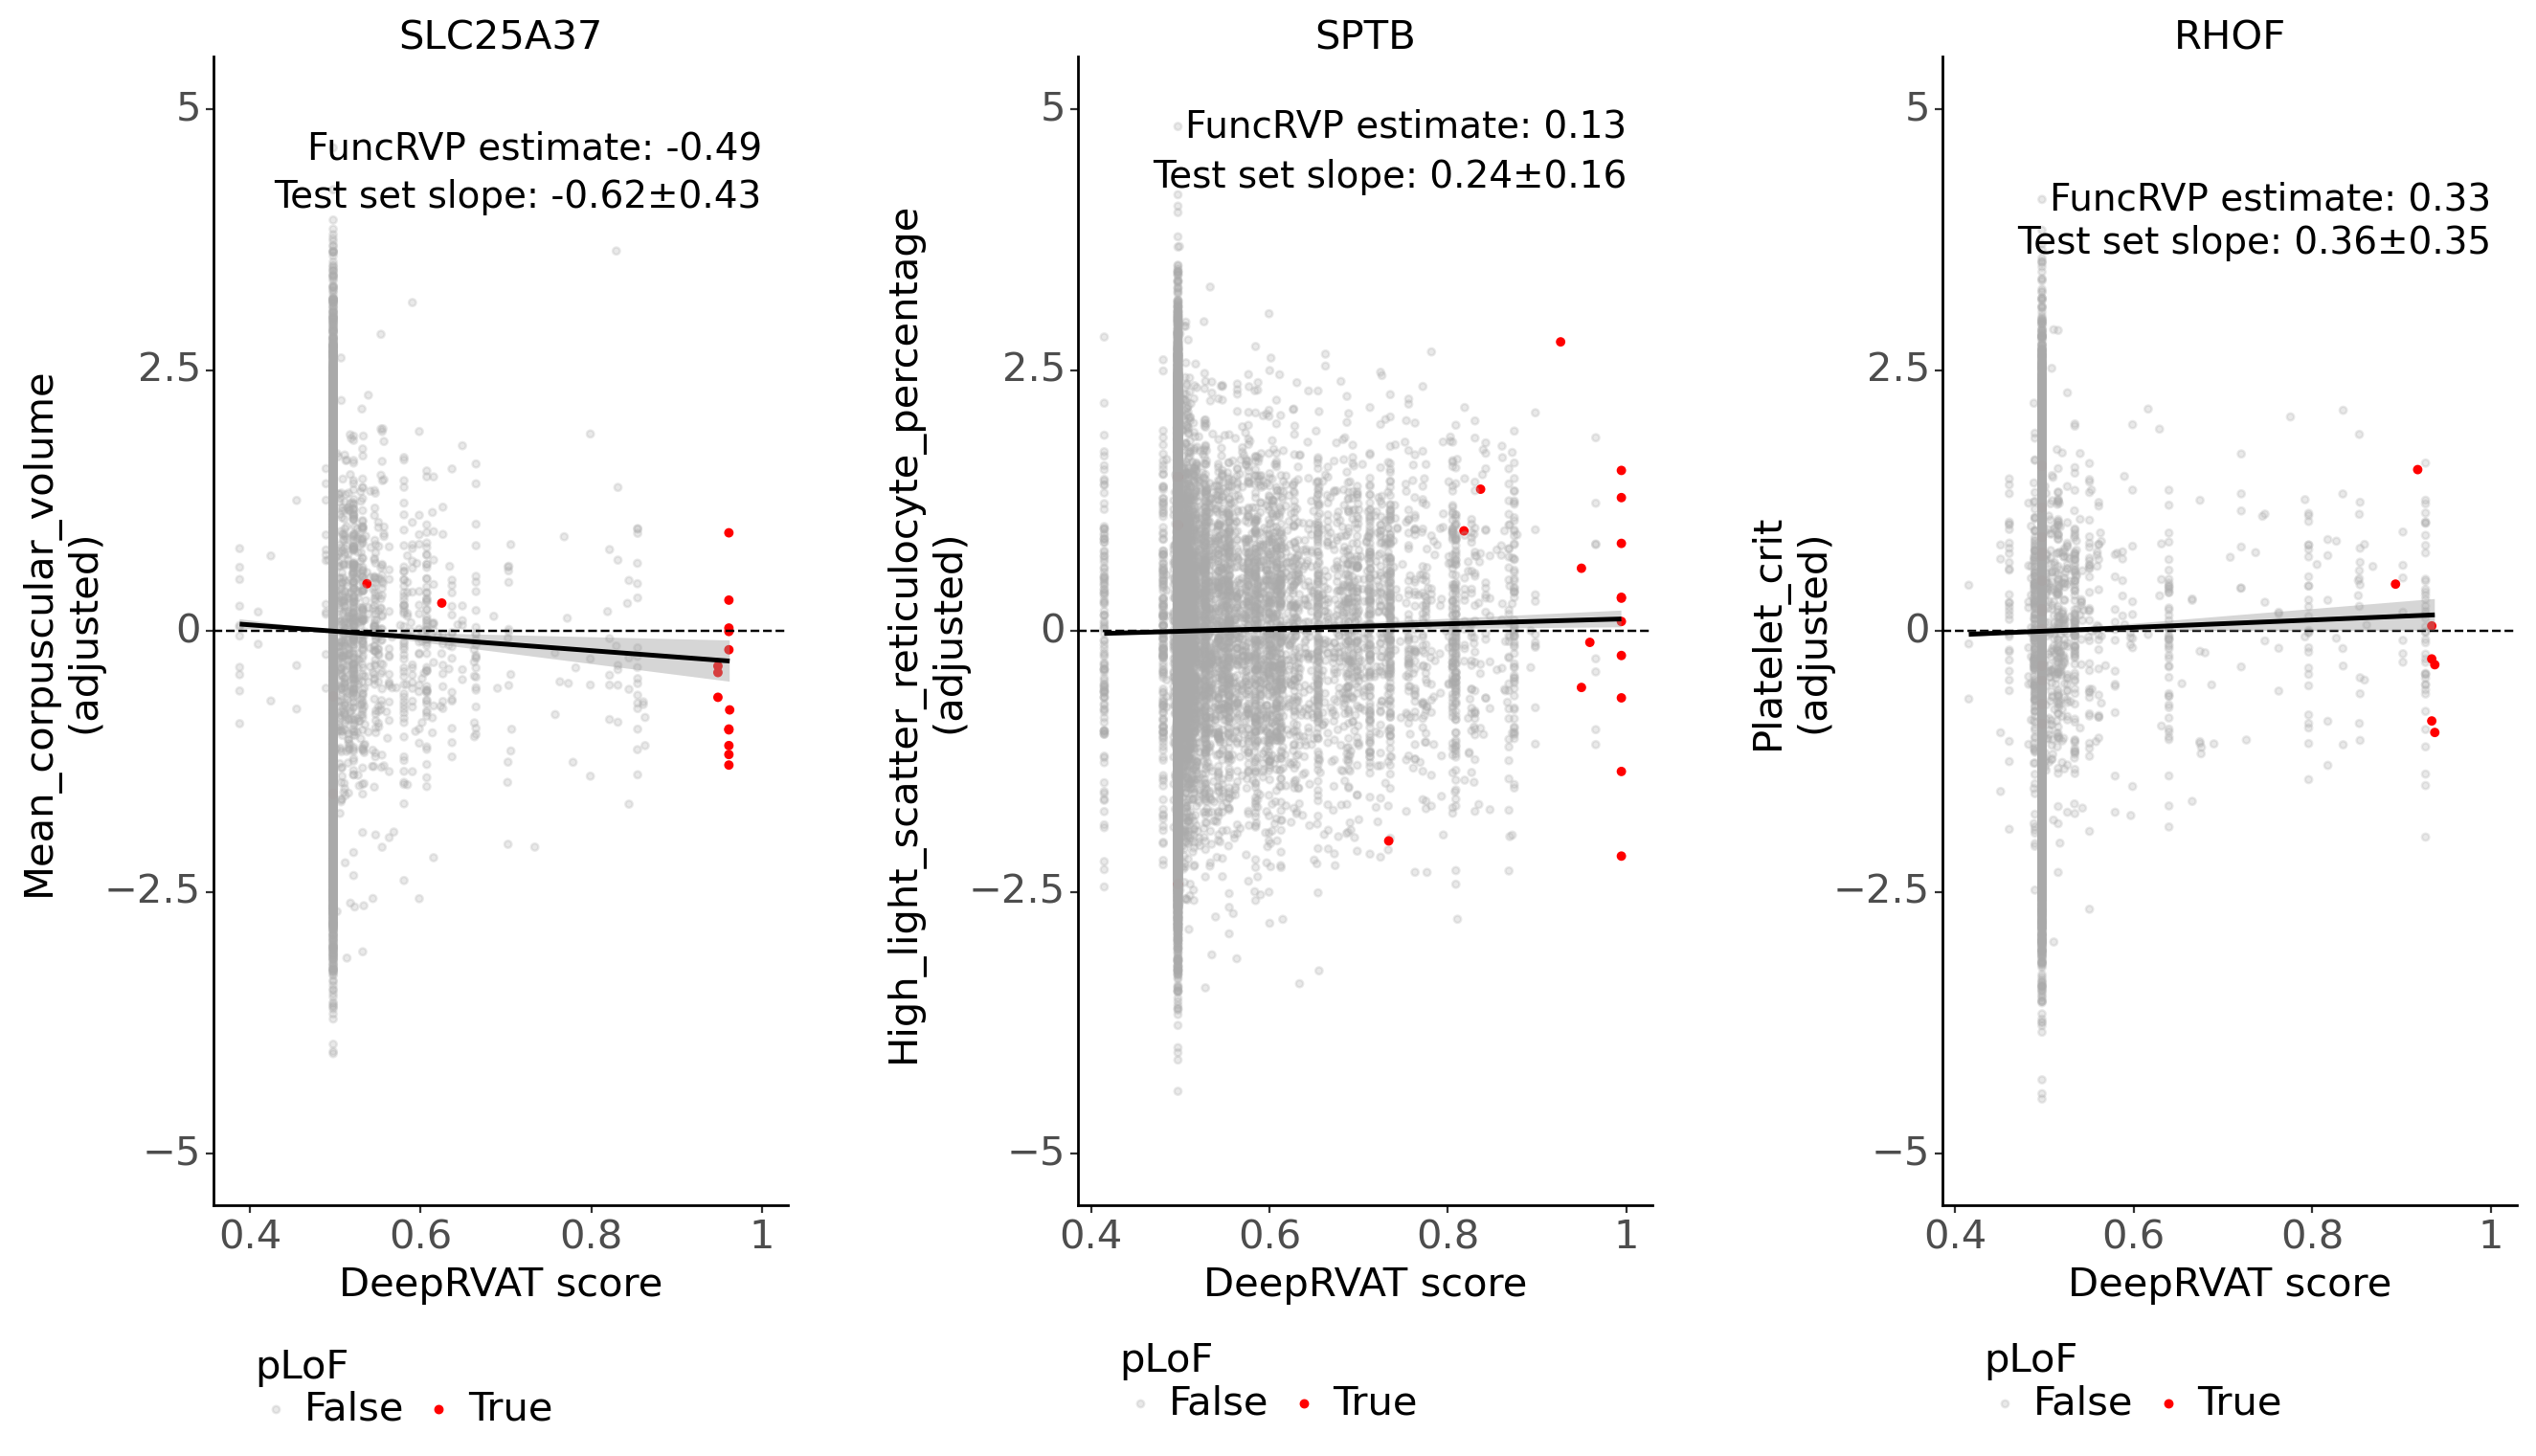

In [110]:
%%time

# g_all = (plot_vec[0]|plot_vec[1]|plot_vec[2]|plot_vec[3]|plot_vec[4])/(plot_vec[5]|plot_vec[6]|plot_vec[7]|plot_vec[8]|plot_vec[10])
g_all = plot_vec[0]|plot_vec[1]|plot_vec[2]#|plot_vec[3]#|plot_vec[4]
g_all

In [ ]:
# g_all.savefig('/s/project/geno2pheno/figures/resub_figures/figure5_allelicSeries.png', dpi=150, bbox_inches='tight')
g_all.savefig('/s/project/geno2pheno/figures/resub_figures/figure6D.png', dpi=150, bbox_inches='tight')


# Venn Diagram

In [ ]:
# bayes_exc_genes = pd.read_parquet('/s/project/geno2pheno/novel_discoveries/repset_merged_assoc_omics_pops_bayesian_v1NEWsplit_deepRVAT.pq')

# bayes_exc_genes = bayes_exc_genes.merge(novel_genes_gwas[['trait', 'gene_id', 'common_var_corrected_olsTest_significant', 'gwas_support', 'slope', 'slope_SE']], on=['trait', 'gene_id'], how='left')
# bayes_exc_genes

In [ ]:
# bayes_exc_genes[['slope', 'slope_SE']] = bayes_exc_genes[['slope', 'slope_SE']].fillna(0)
# bayes_exc_genes[['common_var_corrected_olsTest_significant', 'gwas_support']] = bayes_exc_genes[['common_var_corrected_olsTest_significant', 'gwas_support']].fillna(0).astype('bool')
# bayes_exc_genes


In [68]:
bayes_exc_genes = pd.read_parquet('/s/project/geno2pheno/novel_discoveries/repset_merged_GWAS_post_clumping_omics_pops_bayesian_v1NEWsplit_deepRVAT_plot_ready.pq')
# novel_genes_gwas['common_var_corrected_olsTest_significant'] = novel_genes_gwas['slope_pval'] <= 0.05

bayes_exc_genes


,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,ols_pval,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,common_var_corrected_olsTest_significant,gwas_support,slope,slope_SE
0,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,0.942018,1.236709,False,-0.174696,0.111134,0.028586,False,0.915219,False,False,False,False,False,0.0,0.0
1,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,Calcium,30680,0.548788,0.345620,False,-0.003279,0.026749,0.368853,False,0.913263,False,False,False,False,False,0.0,0.0
2,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,HDL_cholesterol,30760,0.746735,0.596425,False,-0.037084,0.055828,0.088101,False,0.855702,False,False,False,False,False,0.0,0.0
3,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,IGF1,30770,0.510504,0.310250,False,0.001054,0.040032,0.991680,False,0.763079,False,False,False,False,False,0.0,0.0
4,ENSG00000121410,A1BG,omics_pops_bayesian_v1NEWsplit_deepRVAT,LDL_direct,30780,0.777355,0.652387,False,0.035029,0.045893,0.008104,False,0.125460,False,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717700,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,glycated_haemoglobin_hba1c,30750,0.549806,0.346601,False,0.002267,0.018109,0.358041,False,0.960396,False,False,False,False,False,0.0,0.0
717701,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Creatinine,30700,0.560121,0.356666,False,0.002029,0.013411,0.158174,False,0.607580,False,False,False,False,False,0.0,0.0
717702,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Cystatin_C,30720,0.552783,0.349481,False,0.002529,0.019061,0.332895,False,0.434398,False,False,False,False,False,0.0,0.0
717703,ENSG00000036549,ZZZ3,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,0.527534,0.325630,False,0.000590,0.008540,0.306452,False,0.416785,False,False,False,False,False,0.0,0.0


In [72]:
# bayes_exc_genes.to_parquet('/s/project/geno2pheno/novel_discoveries/repset_merged_GWAS_post_clumping_omics_pops_bayesian_v1NEWsplit_deepRVAT_plot_ready.pq')

funcrvp_assoc = bayes_exc_genes[(bayes_exc_genes.significant==True)]
funcrvp_assoc = funcrvp_assoc.merge(count_greater, on='trait', how='left')
# funcrvp_assoc.to_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_FuncRVP_associations_plot_ready.tsv', sep='\t', index=False)

funcrvp_assoc

,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,beta_se,...,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,common_var_corrected_olsTest_significant,gwas_support,slope,slope_SE,gwas_bootstrap_pval
0,ENSG00000148584,A1CF,omics_pops_bayesian_v1NEWsplit_deepRVAT,Gamma_glutamyltransferase,30730,1.000000,12.987510,True,0.689342,0.093852,...,True,6.864770e-06,True,True,True,False,False,0.000000,0.000000,0.0061
1,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,1.000000,inf,True,-1.817395,0.043827,...,True,5.507200e-115,True,True,True,False,False,0.000000,0.000000,0.0003
2,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,HDL_cholesterol,30760,1.000000,inf,True,-1.579147,0.041829,...,True,9.620909e-101,True,True,True,False,False,0.000000,0.000000,0.0000
3,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,LDL_direct,30780,1.000000,9.417212,True,-0.300566,0.048857,...,True,2.955282e-03,True,True,True,False,False,0.000000,0.000000,0.0006
4,ENSG00000165029,ABCA1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Cholesterol,30690,1.000000,inf,True,-0.778533,0.049006,...,True,1.942667e-22,True,True,True,False,False,0.000000,0.000000,0.0018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,ENSG00000166483,WEE1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Mean_corpuscular_haemoglobin,30050,0.999076,3.034463,True,-0.408195,0.131096,...,False,7.949273e-01,False,False,False,False,False,-0.079212,0.258584,0.0000
1110,ENSG00000116729,WLS,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,0.999897,3.988230,True,-0.157434,0.042410,...,False,1.684452e-03,True,True,True,False,False,0.000000,0.000000,0.0000
1111,ENSG00000158125,XDH,omics_pops_bayesian_v1NEWsplit_deepRVAT,Urate,30880,1.000000,10.832482,True,-0.203349,0.030581,...,True,5.708676e-03,True,True,True,False,False,0.000000,0.000000,0.0002
1112,ENSG00000066827,ZFAT,omics_pops_bayesian_v1NEWsplit_deepRVAT,standing_height,50,1.000000,inf,True,0.566240,0.040104,...,True,3.876270e-15,True,True,True,False,False,0.000000,0.000000,0.0000


In [70]:
novel_assoc = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False) & ((bayes_exc_genes.ols_test_nom_significant==False) | (bayes_exc_genes.common_var_corrected_olsTest_significant==True))].reset_index()
novel_assoc = novel_assoc.merge(count_greater, on='trait', how='left')
# novel_assoc.to_csv('/s/project/geno2pheno/novel_discoveries/repset_merged_novel_associations_plot_ready.tsv', sep='\t', index=False)

novel_assoc[novel_assoc.trait=='Urea']

,index,gene_id,gene_name,model,trait,phenocode,pd,neglog_pval,significant,beta,...,ols_significant,ols_test_pval,ols_test_nom_significant,DeepRVAT_significant,Genebass_Backman_significant,common_var_corrected_olsTest_significant,gwas_support,slope,slope_SE,gwas_bootstrap_pval
329,673779,ENSG00000197415,VEPH1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Urea,30670,0.999476,3.280931,True,0.147403,...,False,0.023566,True,False,False,True,False,0.213144,0.094719,0.0967


5

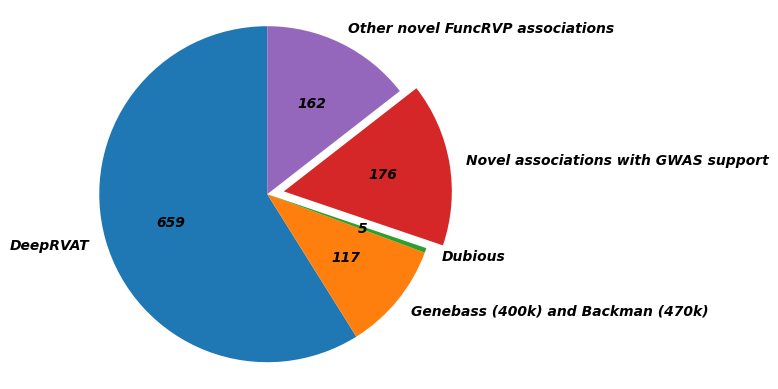

In [29]:
total = bayes_exc_genes[(bayes_exc_genes.significant==True)].shape[0]
# deeprvat = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.DeepRVAT_significant==True)].shape[0]
deeprvat = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==True)].shape[0]
gb = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==True)].shape[0]
dubious = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.ols_test_nom_significant==True) & (bayes_exc_genes.common_var_corrected_olsTest_significant==False)].shape[0]
gwas_supp = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False) & (bayes_exc_genes.gwas_support==True)].shape[0]

# gwas_supp_test_rep = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False) & (bayes_exc_genes.gwas_support==True) & (bayes_exc_genes.common_var_corrected_olsTest_significant==True)].shape[0]
# gwas_supp_no_test = bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.DeepRVAT_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False) & (bayes_exc_genes.gwas_support==True) & (bayes_exc_genes.common_var_corrected_olsTest_significant==False)].shape[0]
remaining = total - (deeprvat + gb + gwas_supp)

# labels = ['DeepRVAT 470k\n(34/41 traits)', 'Genebass (400k) and Backman (470k)', 'Novel associations with GWAS support\nand replicated on the test set', 'Other novel FuncRVP associations']
labels = ['DeepRVAT', 'Genebass (400k) and Backman (470k)', 'Dubious', 'Novel associations with GWAS support', 'Other novel FuncRVP associations']
sizes = [deeprvat, gb, dubious, gwas_supp, remaining]
explode = (0, 0, 0, 0.1, 0)

p, tx, autotexts = plt.pie(sizes, explode=explode, labels=labels, autopct="", startangle=90, textprops={'weight': 'bold', 'style':'italic'})#,  wedgeprops = {'linewidth': 3})

for i, a in enumerate(autotexts):
    a.set_text("{}".format(sizes[i]))

plt.axis('equal')
plt.savefig('/s/project/geno2pheno/figures/resub_figures/figure5_venn.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
bayes_exc_genes[(bayes_exc_genes.significant==True) & (bayes_exc_genes.ols_significant==False) & (bayes_exc_genes.Genebass_Backman_significant==False) & (bayes_exc_genes.gwas_support==False) & (bayes_exc_genes.ols_test_nom_significant==True)].shape[0]


70

# Old plotting code

In [ ]:
import patchworklib as pw

def make_plot(gene_name, trait):
    al_plot = (pn.ggplot(plot_dt[plot_dt.gene_name == gene_name], 
                     pn.aes(x='deepRVAT', y='residual')) 
           + pn.geom_point(pn.aes(color='pLoF'), alpha=0.5, size=1)
           + pn.geom_hline(yintercept = 0, linetype='dashed')
           # + pn.geom_smooth(method='lm')
           + pn.stat_smooth(method='lm')
           + pn.scale_color_manual(name='pLoF', values = ["darkgrey", "red"])
           + pn.ylab(f"{trait}\n(adjusted)")
           + pn.xlab("DeepRVAT score")
           # + pn.geom_text(pn.aes(x=np.Inf, y=np.Inf, label="p_label"), data=plt_genes[(plt_genes.trait == trait) & (plt_genes.gene_name == gene_name)], size=13)
           # + pn.geom_text(pn.aes(x=np.Inf, y=np.Inf, label="beta_label"), data=plt_genes[(plt_genes.trait == trait) & (plt_genes.gene_name == gene_name)], size=13)
           # + pn.geom_text(pn.aes(x=0.755, y=3.5, label="p_label"), data=plt_genes[(plt_genes.trait == trait) & (plt_genes.gene_name == gene_name)], size=13)
           + pn.geom_text(pn.aes(x=1, y=4, label="FuncRVP_estimate"), data=omim_assocs[(omim_assocs.trait == trait) & (omim_assocs.gene_name == gene_name)], size=14, ha = "right")
           + pn.geom_text(pn.aes(x=1, y=3.7, label="slope_label"), data=omim_assocs[(omim_assocs.trait == trait) & (omim_assocs.gene_name == gene_name)], size=14, ha = "right")
           # + pn.geom_text(pn.aes(x=1, y=3.4, label="p_label"), data=plt_genes[(plt_genes.trait == trait) & (plt_genes.gene_name == gene_name)], size=14, ha = "right")
           + pn.ggtitle(f"{gene_name}")
           # + pn.ylim([-4,4])
           + pn.theme_classic()           
           + pn.theme(text=pn.element_text(size=15),
                      plot_title = pn.element_text(hjust = 0.5),
                      legend_position='bottom'))

    return al_plot

In [14]:
%%time

plot_vec = []
# for tr in trait_gene_dict:
for tr in ['Lymphocyte_percentage', 'Platelet_crit']:
    plot_vec.append(pw.load_ggplot(make_plot(gene_name=trait_gene_dict[tr], trait=tr), figsize=(3,6)))


CPU times: user 59.5 s, sys: 13.9 s, total: 1min 13s
Wall time: 1min


CPU times: user 128 ms, sys: 140 ms, total: 268 ms
Wall time: 117 ms


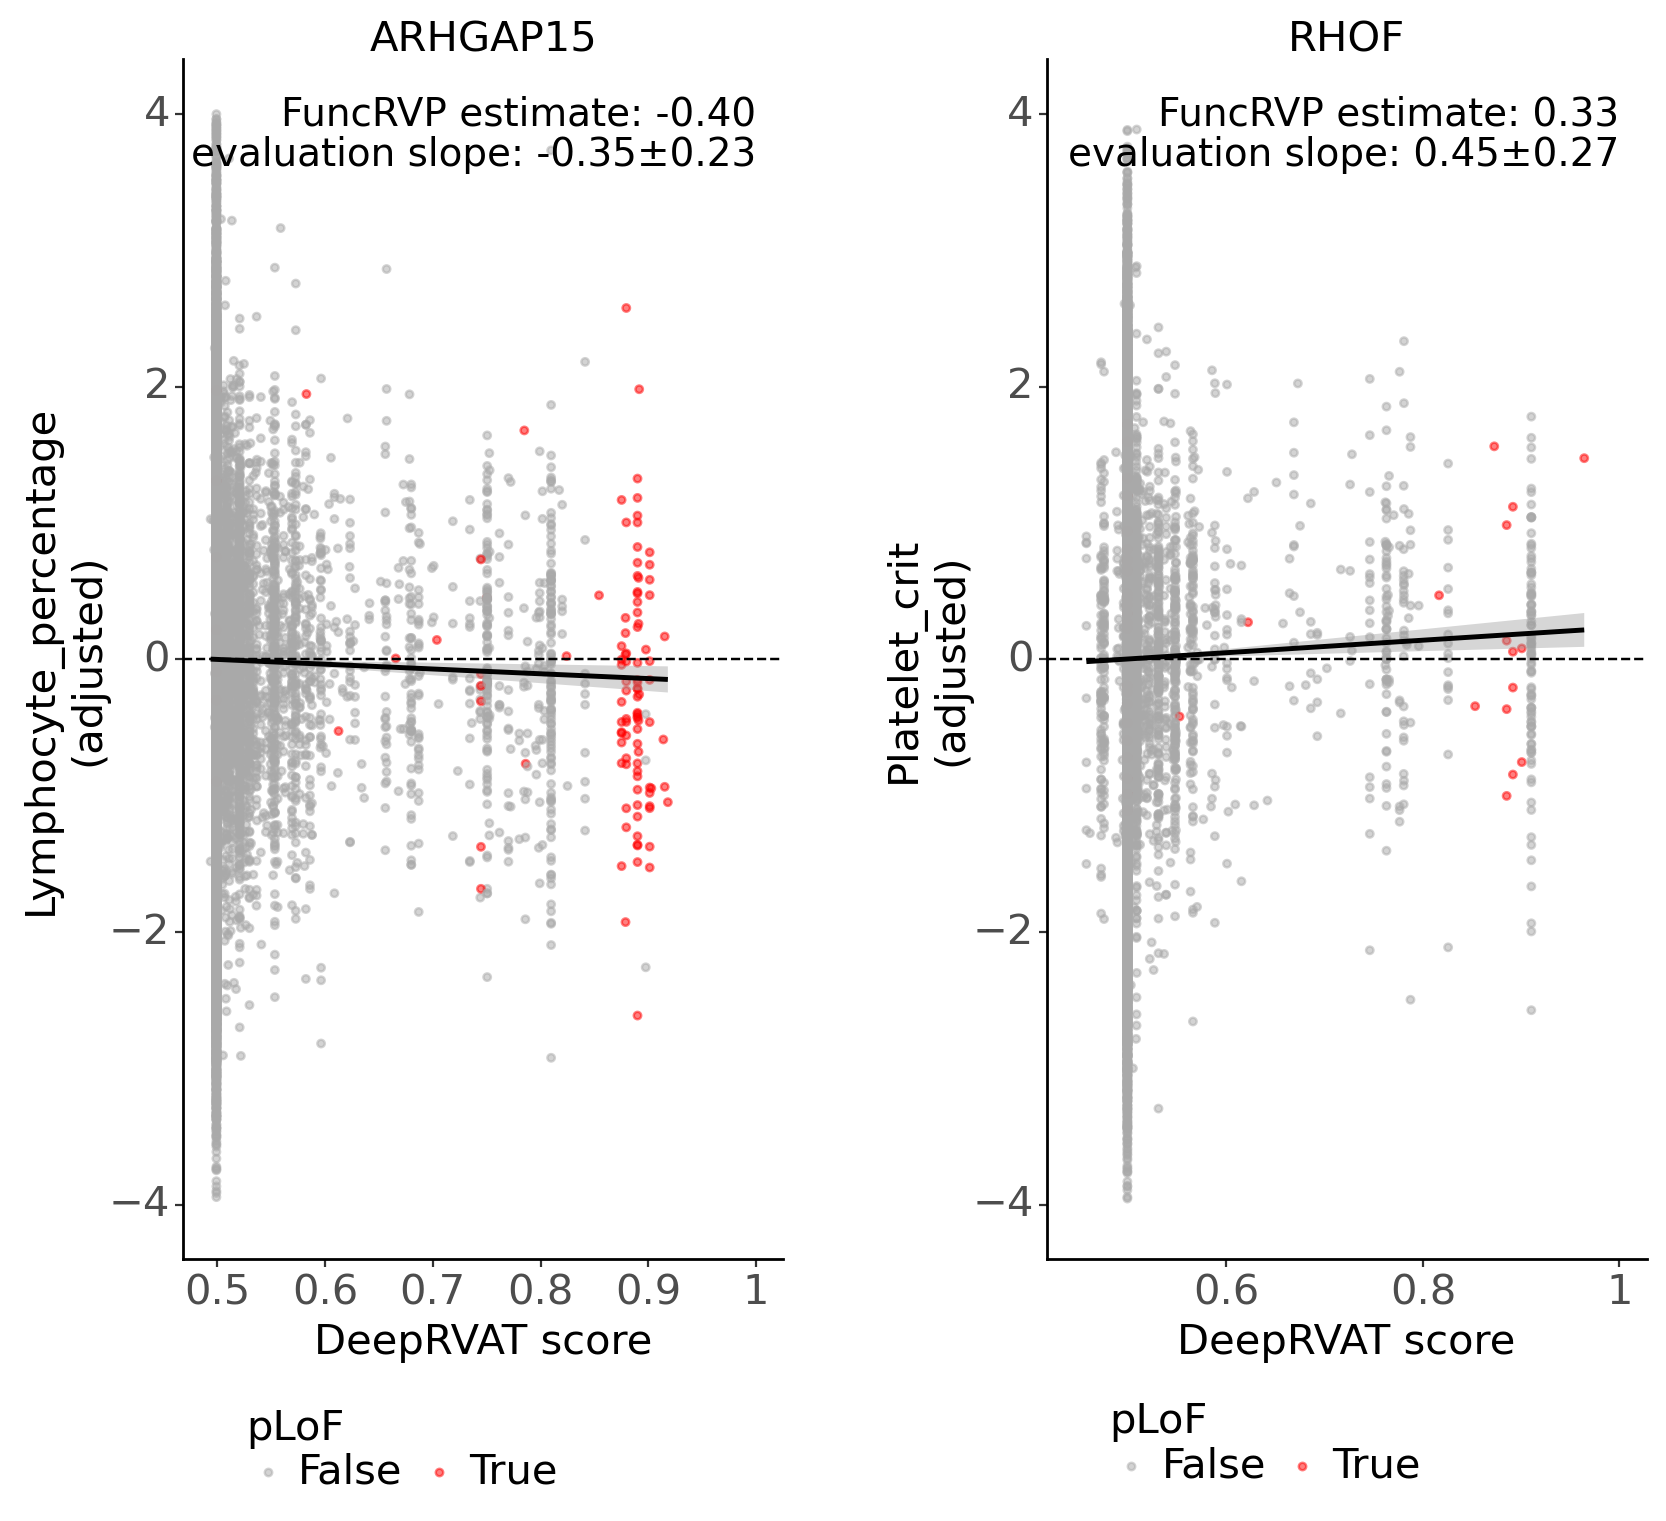

In [15]:
%%time

# g1234 = (plot_vec[0]|plot_vec[1])/(plot_vec[2]|plot_vec[3])
# g1234 = plot_vec[0]|plot_vec[1]|plot_vec[2]|plot_vec[3]
g1234 = plot_vec[0]|plot_vec[1]
g1234

In [ ]:
g1234.savefig('/s/project/geno2pheno/figures/figure_6_new.png', dpi=96)

# Old code to filter for exclusive discoveries

In [9]:

trait_cols = [f'{tr}_common_resid' for tr in trait_gene_dict]

# 200K UK Biobank
# deeprvat_gt = pd.read_parquet("/s/project/uk_biobank/processed/derived_datasets/ukbb_wes_200k_DeepRVAT_mean_6_0.parquet", columns=list(plt_genes.gene_id)).reset_index()
# deeprvat_gt = pd.melt(deeprvat_gt, id_vars='individual', value_name='deeprvat')

# plof_gt = pd.read_parquet("/s/project/uk_biobank/processed/derived_datasets/ukbb_wes_200k_ensembl_loftee_plof_binarized_pivot.parquet", columns=list(plt_genes.gene_id)).reset_index()
# plof_gt = pd.melt(plof_gt, id_vars='individual', value_name='plof')

# pheno_dt = pd.read_parquet("/s/project/uk_biobank/processed/derived_datasets/ukbb_common_traits_and_covariates_with_split_and_residuals_filteredv3.parquet", columns=['individual']+trait_cols)
# # geno_dt = deeprvat_gt.merge(plof_gt, on=['individual', 'gene']).merge(gene_names, left_on='gene', right_on='gene_id')
# plot_dt = pheno_dt.merge(deeprvat_gt.merge(plof_gt, on=['individual', 'gene']), on='individual').merge(gene_names, left_on='gene', right_on='gene_id').drop(columns='gene')
# plot_dt

# 300K UK Biobank
deeprvat_gt = pd.read_parquet("/s/project/uk_biobank/processed/derived_datasets/ukbb_wes_300k_DeepRVAT_mean_6_0.parquet", columns=list(plt_genes.gene_id)).reset_index()
deeprvat_gt = pd.melt(deeprvat_gt, id_vars='individual', value_name='deeprvat')

plof_gt = pd.read_parquet("/s/project/uk_biobank/processed/derived_datasets/ukbb_wes_500k_vep_plof_binarized.parquet", columns=list(plt_genes.gene_id)).reset_index()
plof_gt = pd.melt(plof_gt, id_vars='individual', value_name='plof')

pheno_dt = pd.read_parquet("/s/project/uk_biobank/processed/derived_datasets/ukbb_common_traits_and_covariates_with_split_and_residuals_300k_filteredv3.parquet", columns=['individual']+trait_cols)
plot_dt = pheno_dt.merge(deeprvat_gt.merge(plof_gt, on=['individual', 'gene']), on='individual').merge(gene_names, left_on='gene', right_on='gene_id').drop(columns='gene')
plot_dt


,individual,Lymphocyte_percentage_common_resid,Platelet_crit_common_resid,deeprvat,plof,gene_id,gene_name
0,1000018,-0.347294,0.214849,0.499158,False,ENSG00000075884,ARHGAP15
1,1000020,0.344209,-0.207243,0.499158,False,ENSG00000075884,ARHGAP15
2,1000092,0.575596,-0.940312,0.499158,False,ENSG00000075884,ARHGAP15
3,1000107,-1.887854,-1.010038,0.499158,False,ENSG00000075884,ARHGAP15
4,1000110,-0.145879,-0.556104,0.499158,False,ENSG00000075884,ARHGAP15
...,...,...,...,...,...,...,...
421079,6026061,0.277979,-0.292084,0.499158,False,ENSG00000139725,RHOF
421080,6026118,0.005337,-0.387408,0.499158,False,ENSG00000139725,RHOF
421081,6026137,-1.850075,0.554590,0.499158,False,ENSG00000139725,RHOF
421082,6026151,1.287351,-0.372026,0.499158,False,ENSG00000139725,RHOF


In [2]:
import pandas as pd

# Read parquet files and convert to pandas DataFrame
# dt = pd.read_parquet('/s/project/geno2pheno/predictions/bayesian/best_model_pred/v108cov_deepRVAT_genes_extended.pq')
# dt_ols = pd.read_parquet('/s/project/geno2pheno/predictions/bayesian/best_model_pred/ols_filteredv3_deepRVAT_genes_extended.pq')

dt = pd.read_parquet('/s/project/geno2pheno/predictions/bayesian/fixed_arch/v1NEWsplit_deepRVAT_testsplit0.25_omics_pops_genes_extended.pq')
dt_ols = pd.read_parquet('/s/project/geno2pheno/predictions/bayesian/at_filteredv3_deepRVAT_0.25_genes_NEWsplit.pq')

# Concatenate DataFrames
dt = pd.concat([dt[['model', 'trait', 'phenocode', 'gene_id', 'pd', 'significant', 'replicated', 'beta']], #'neglog_pval'
                dt_ols[['model', 'trait', 'phenocode', 'gene_id', 'pval', 'significant', 'replicated', 'beta']]], 
                ignore_index=True)

# Load gene names
gene_names = pd.read_csv('/s/project/geno2pheno/data/hgnc2ensg.tsv', sep='\t')[['Ensembl gene ID', 'Approved symbol']].drop_duplicates().rename(columns={'Ensembl gene ID':'gene_id', 'Approved symbol':'gene_name'})

# Merge table with gene names
dt = dt.merge(gene_names, on='gene_id')
# dt['significant'] = np.where(dt['pd']>0.999, True, False)
dt


,model,trait,phenocode,gene_id,pd,significant,replicated,beta,pval,gene_name
0,omics_pops_bayesian_v1NEWsplit_deepRVAT,Apolipoprotein_A,30630,ENSG00000000419,0.590237,False,False,-0.004280,NaN,DPM1
1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Calcium,30680,ENSG00000000419,0.539387,False,False,-0.002821,NaN,DPM1
2,omics_pops_bayesian_v1NEWsplit_deepRVAT,HDL_cholesterol,30760,ENSG00000000419,0.597544,False,False,-0.004318,NaN,DPM1
3,omics_pops_bayesian_v1NEWsplit_deepRVAT,IGF1,30770,ENSG00000000419,0.562862,False,False,0.002383,NaN,DPM1
4,omics_pops_bayesian_v1NEWsplit_deepRVAT,LDL_direct,30780,ENSG00000000419,0.561586,False,False,-0.003097,NaN,DPM1
...,...,...,...,...,...,...,...,...,...,...
1435405,ols_deepRVAT_cov,glycated_haemoglobin_hba1c,30750,ENSG00000273274,NaN,False,False,0.025445,0.846567,ZBTB8B
1435406,ols_deepRVAT_cov,Creatinine,30700,ENSG00000273274,NaN,False,False,-0.206376,0.057430,ZBTB8B
1435407,ols_deepRVAT_cov,Cystatin_C,30720,ENSG00000273274,NaN,False,False,-0.195868,0.111973,ZBTB8B
1435408,ols_deepRVAT_cov,Gamma_glutamyltransferase,30730,ENSG00000273274,NaN,False,False,-0.089546,0.476389,ZBTB8B


In [5]:
trait_gene_dict = {
    'Lymphocyte_percentage':'ARHGAP15',   # 30180
    'Platelet_crit':'RHOF',               # 30090
}

for tr in trait_gene_dict:
    print(tr, trait_gene_dict[tr])

Lymphocyte_percentage ARHGAP15
Platelet_crit RHOF


In [6]:
a = pd.concat([dt[(dt.trait==tr) & (dt.gene_name == trait_gene_dict[tr]) & (dt.model=='ols_deepRVAT_cov')] for tr in trait_gene_dict])
a


,model,trait,phenocode,gene_id,pd,significant,replicated,beta,pval,gene_name
101075,ols_deepRVAT_cov,Lymphocyte_percentage,30180,ENSG00000075884,NaN,True,False,-0.424731,8.416289e-07,ARHGAP15
606201,ols_deepRVAT_cov,Platelet_crit,30090,ENSG00000139725,NaN,False,False,0.392965,8.007932e-05,RHOF


In [7]:
# plt_genes = pd.concat([dt[(dt.trait==tr) & (dt.gene_name == trait_gene_dict[tr]) & (dt.model=='omics_pops_bayesian_v108cov_deepRVAT')] for tr in trait_gene_dict])
plt_genes = pd.concat([dt[(dt.trait==tr) & (dt.gene_name == trait_gene_dict[tr]) & (dt.model=='omics_pops_bayesian_v1NEWsplit_deepRVAT')] for tr in trait_gene_dict])
plt_genes

,model,trait,phenocode,gene_id,pd,significant,replicated,beta,pval,gene_name
101034,omics_pops_bayesian_v1NEWsplit_deepRVAT,Lymphocyte_percentage,30180,ENSG00000075884,0.999999,True,False,-0.403094,NaN,ARHGAP15
606160,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,ENSG00000139725,0.999838,True,False,0.329556,NaN,RHOF


In [8]:
nom_pval_dt = pd.concat([dt[(dt.trait==tr) & (dt.gene_name == trait_gene_dict[tr]) & (dt.model=='ols_deepRVAT_cov')] for tr in trait_gene_dict])
nom_pval_dt['nom_pval'] = np.exp(-nom_pval_dt['pval'])
# nom_pval_dt['nom_pval'] = np.exp(-nom_pval_dt['neglog_pval'])
# nom_pval_dt
plt_genes = pd.merge(plt_genes, nom_pval_dt[['gene_id', 'nom_pval']], on='gene_id')
plt_genes

,model,trait,phenocode,gene_id,pd,significant,replicated,beta,pval,gene_name,nom_pval
0,omics_pops_bayesian_v1NEWsplit_deepRVAT,Lymphocyte_percentage,30180,ENSG00000075884,0.999999,True,False,-0.403094,NaN,ARHGAP15,0.999999
1,omics_pops_bayesian_v1NEWsplit_deepRVAT,Platelet_crit,30090,ENSG00000139725,0.999838,True,False,0.329556,NaN,RHOF,0.999920
